# Experiment 02: Influence of weight coefficients

In [1]:
%matplotlib inline

import os
import sys
import copy
import time
import pickle
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

## Loading data 2D

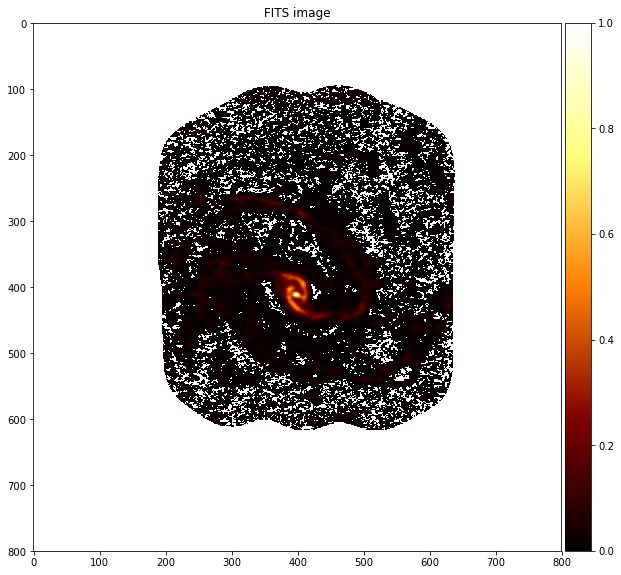

In [2]:
"""
Loading data
"""

fits_path = '../data/images/M100_combine_CO_cube.image.mom0.pbcor.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

/home/mavillan/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3902: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = self.filled(0).__eq__(other)
Widget Javascript not detected.  It may not be installed or enabled properly.


<function graph.thresholded_image_plot>

## `Case 1 `:   $\alpha_1 \in [0,10]$

In [4]:
elm_list = list()
alpha1 = np.arange(0.,10.1,0.5)

for a1 in alpha1:
    # common parameters
    minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
    maxsig = 30*minsig

    # number of points of each type
    Nc = 300
    #Nb = int(0.2* np.sum(boundary_map(data, base_level))) #20% of boundary pixels
    Nb = int(0.2*Nc)
    Ne = 4*Nc-Nb

    # points generation
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)

    # right format
    xc = center_points[:,0]
    yc = center_points[:,1]
    xe = collocation_points[:,0]
    ye = collocation_points[:,1]
    xb = boundary_points[:,0]
    yb = boundary_points[:,1]

    ## visualizing the choosen points
    #points_plot(data, center_points=center_points, title="Center Points")
    #points_plot(data, center_points=collocation_points, title="Collocation Points")


    ####################################
    # Initial parameters estimation
    ####################################
    c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


    #solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
    #params_plot(c0, sig0, xc, yc)
    #params_distribution_plot(c0, sig0)
    elm_list.append( ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=a1, lamb1=1., b=0., lamb2=1.,
                    d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.) )

../lib/points_generation.py:28: RuntimeWarning: invalid value encountered in less_equal
  mask = data <= base_level
../lib/points_generation.py:126: RuntimeWarning: invalid value encountered in greater
  pixel_map = data > base_level
../lib/variational.py:79: RuntimeWarning: invalid value encountered in greater
  self.mask = data > base_level


##########################################################################################
Processing example with alpha1: 0.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5377254486083984 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

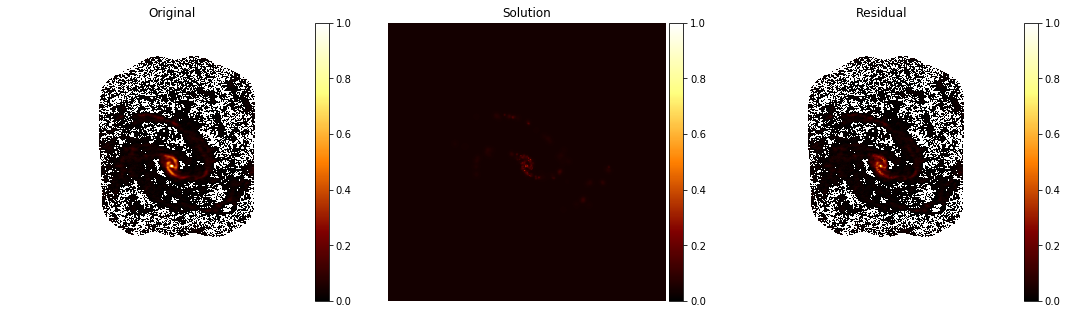

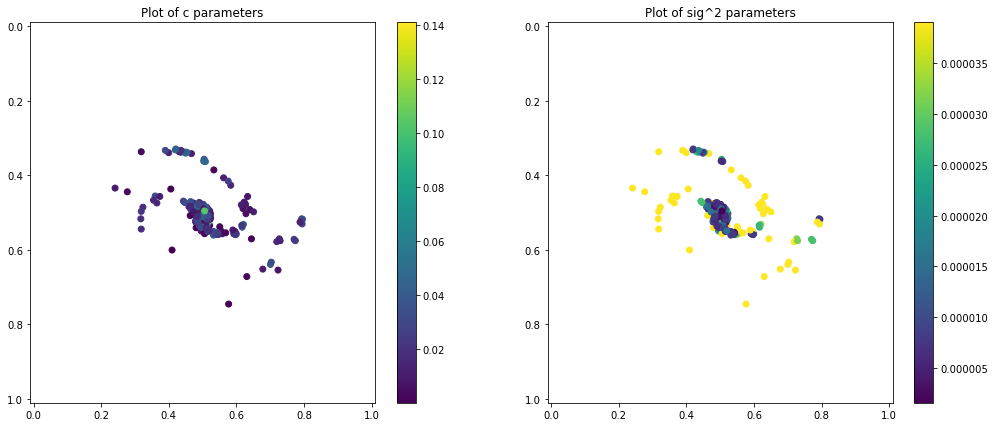

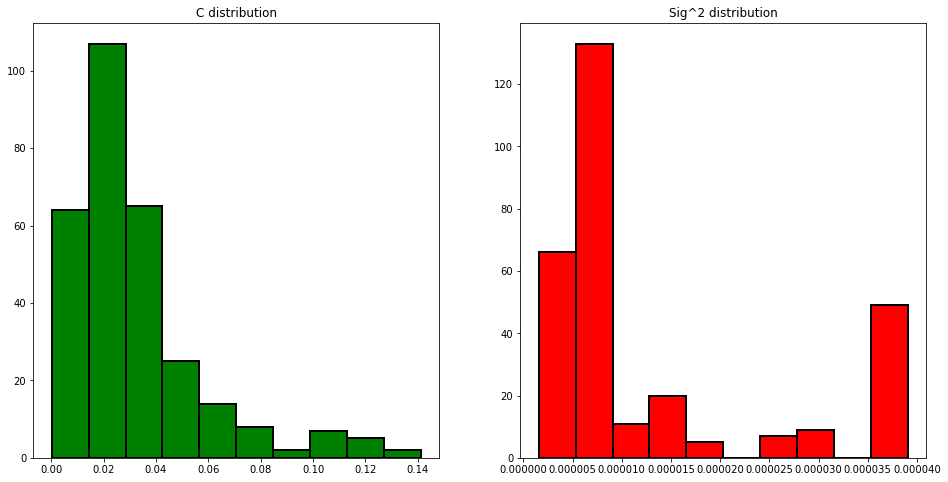

##########################################################################################
Processing example with alpha1: 0.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.535499095916748 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mean

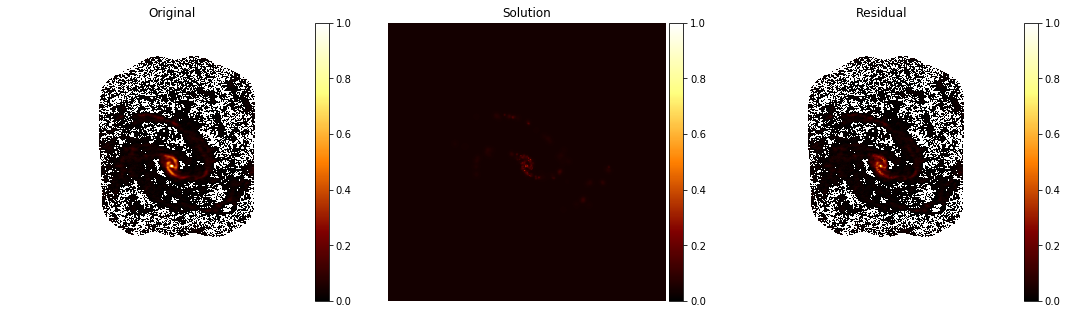

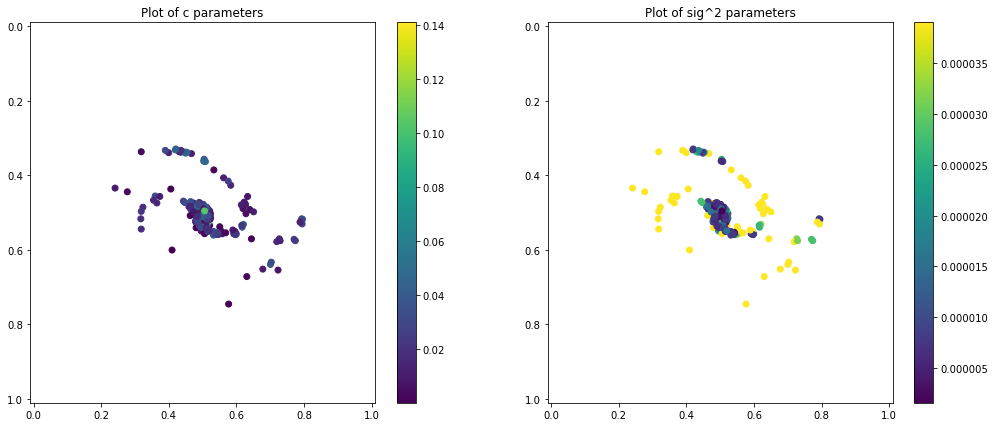

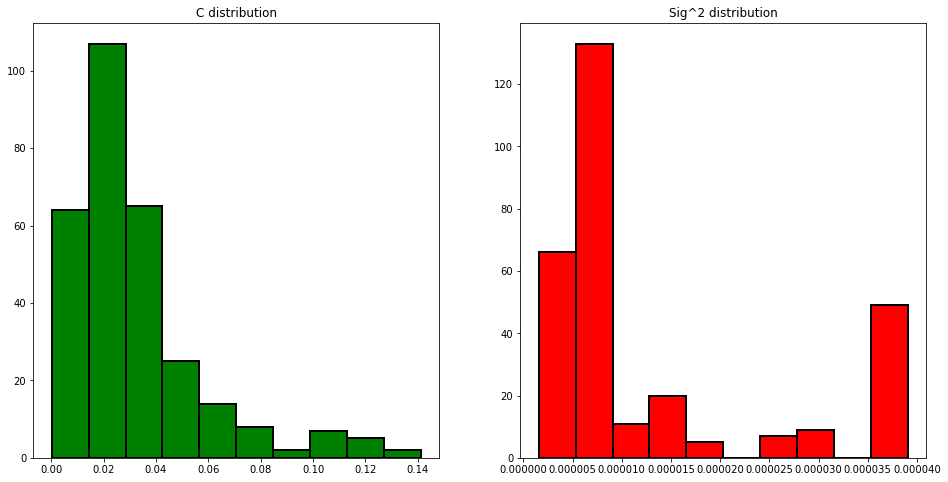

##########################################################################################
Processing example with alpha1: 1.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.533914566040039 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mean

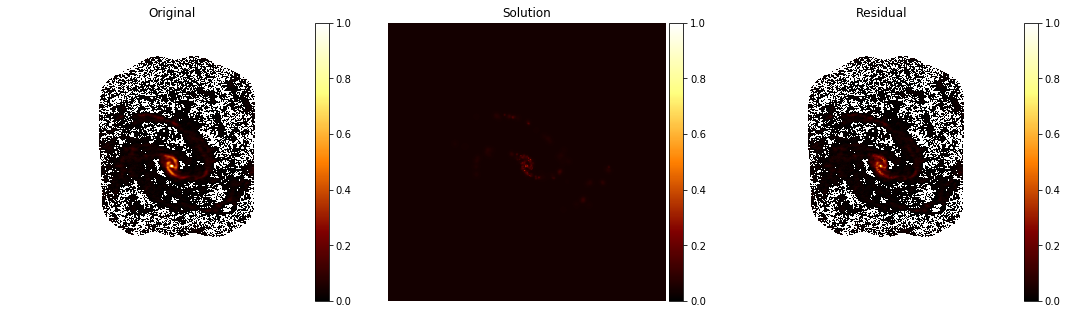

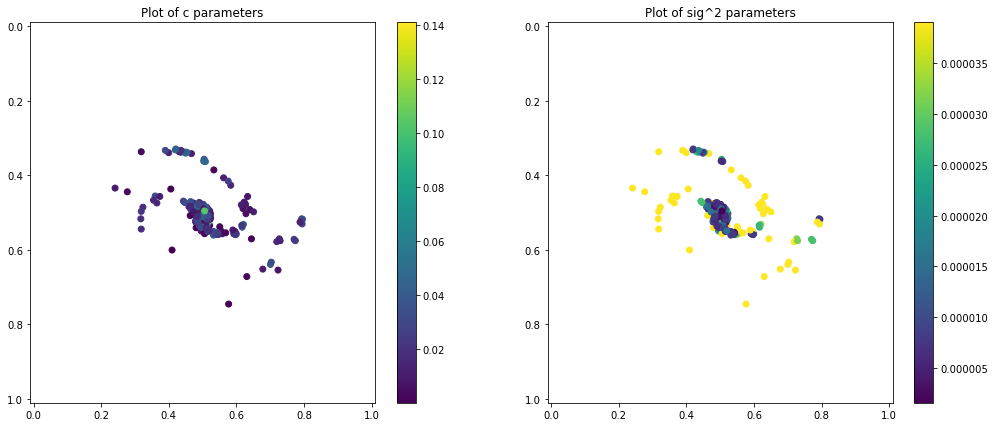

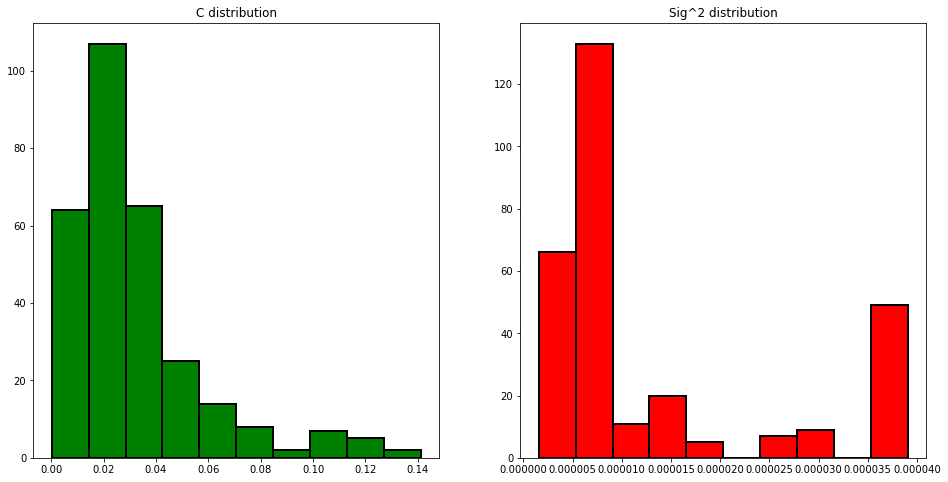

##########################################################################################
Processing example with alpha1: 1.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5278143882751465 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

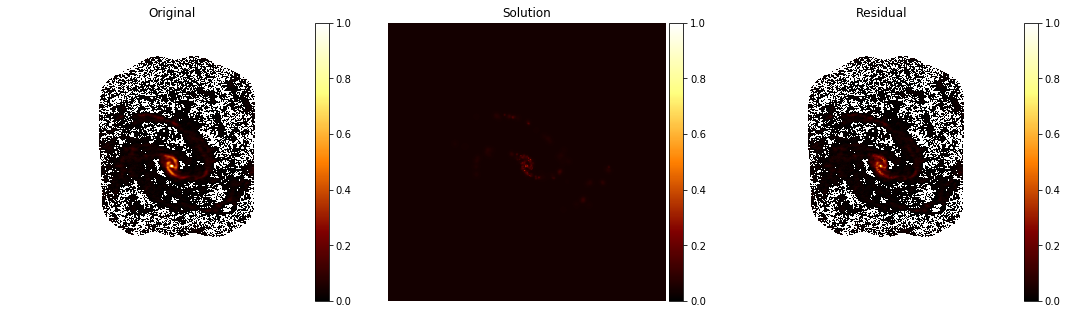

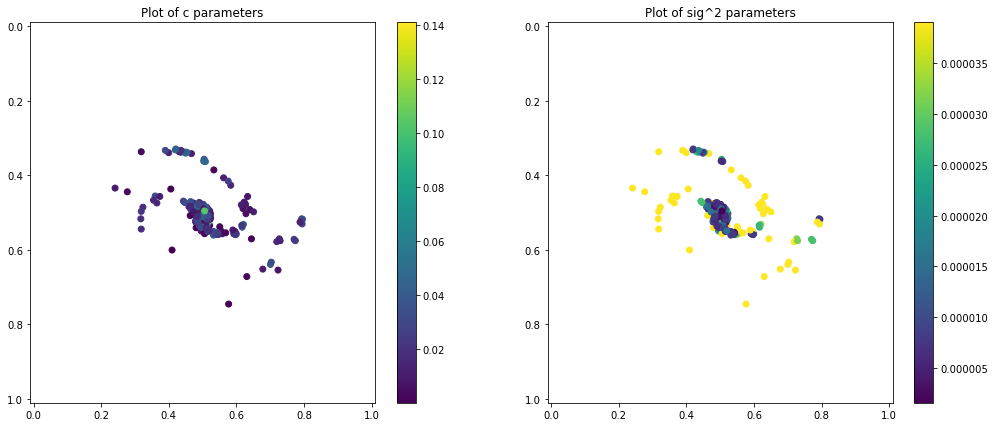

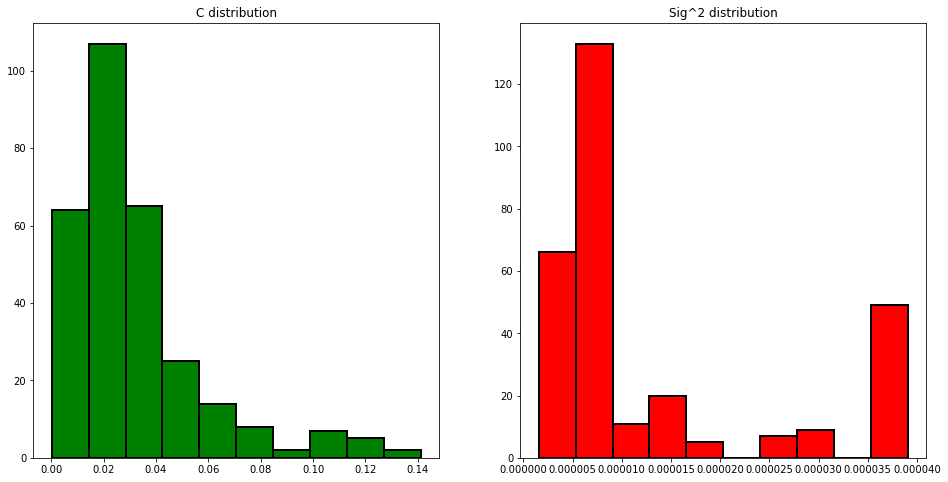

##########################################################################################
Processing example with alpha1: 2.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5282514095306396 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

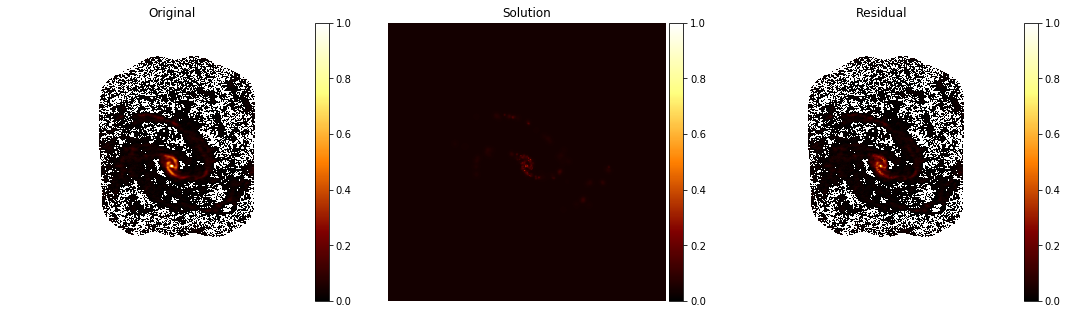

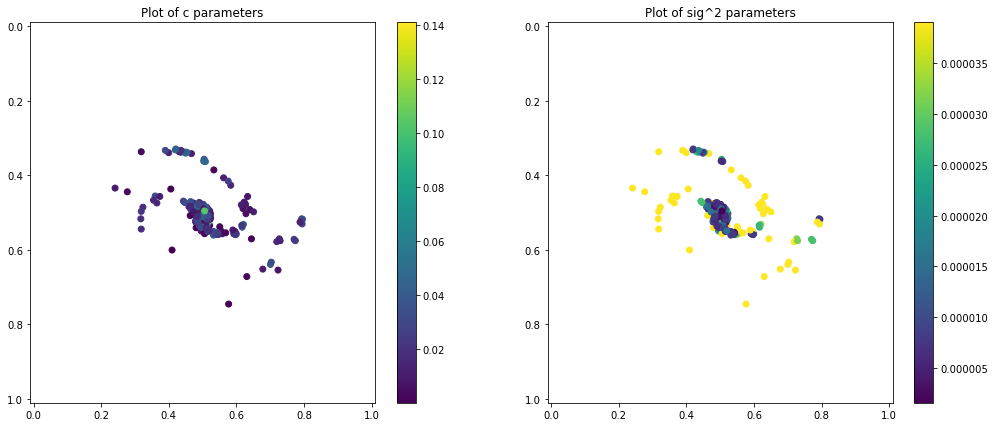

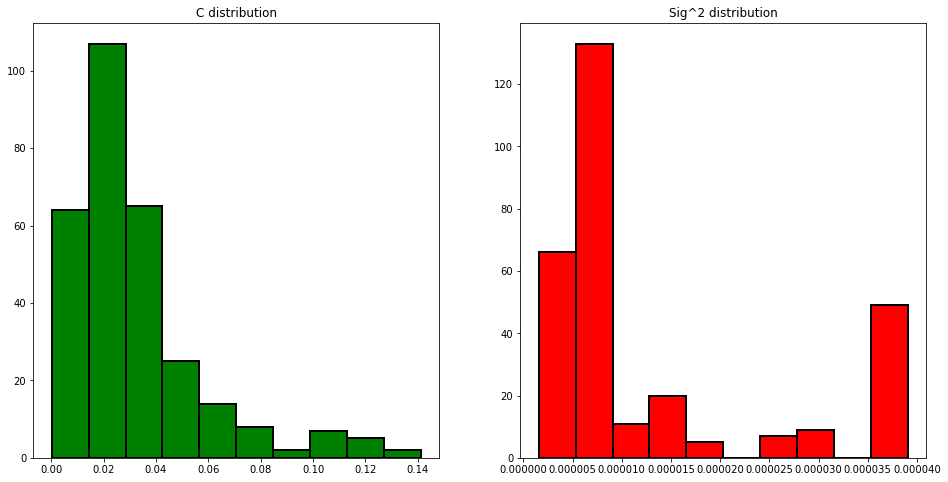

##########################################################################################
Processing example with alpha1: 2.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5607473850250244 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

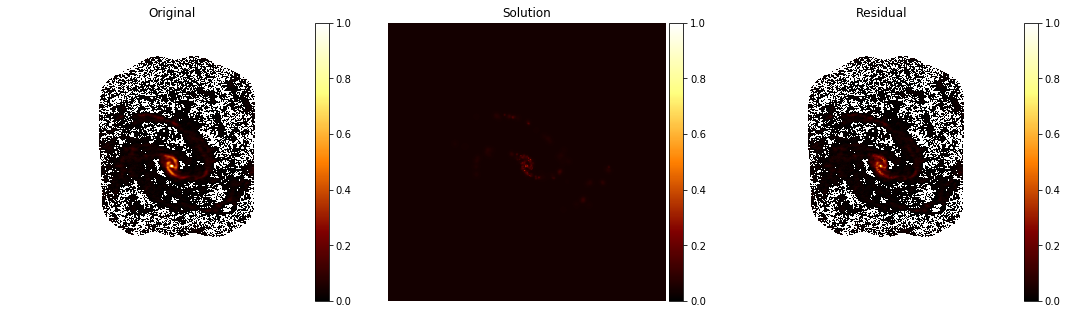

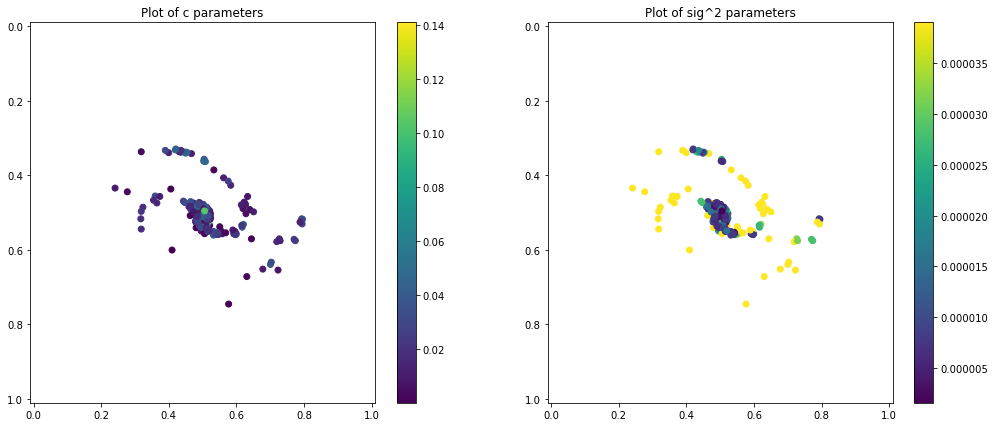

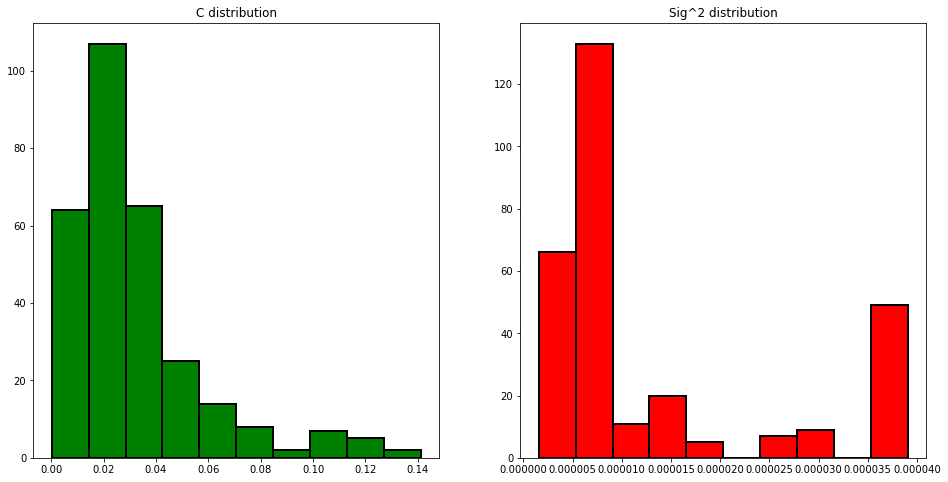

##########################################################################################
Processing example with alpha1: 3.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.530289888381958 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mean

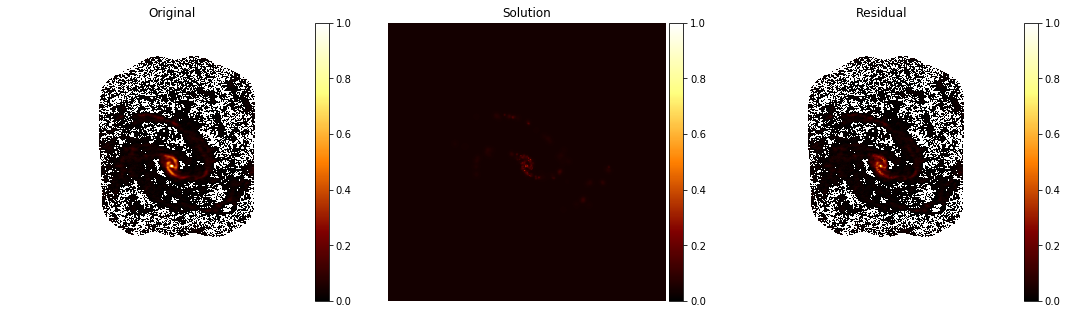

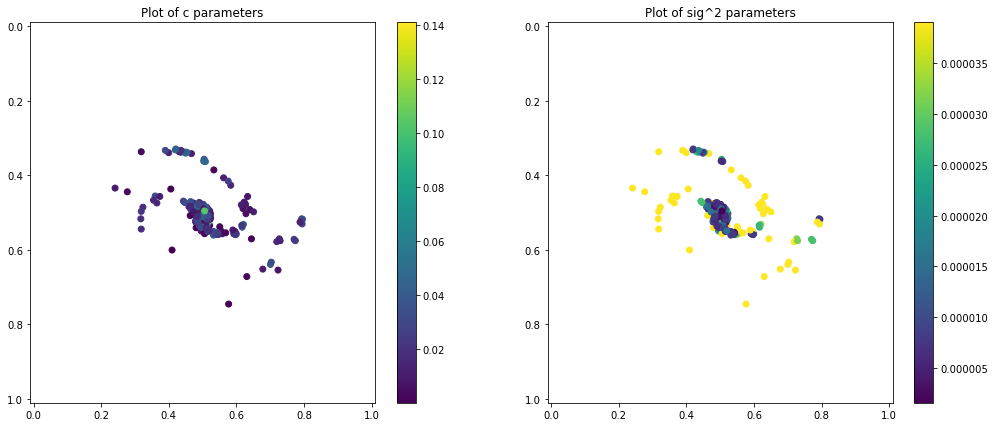

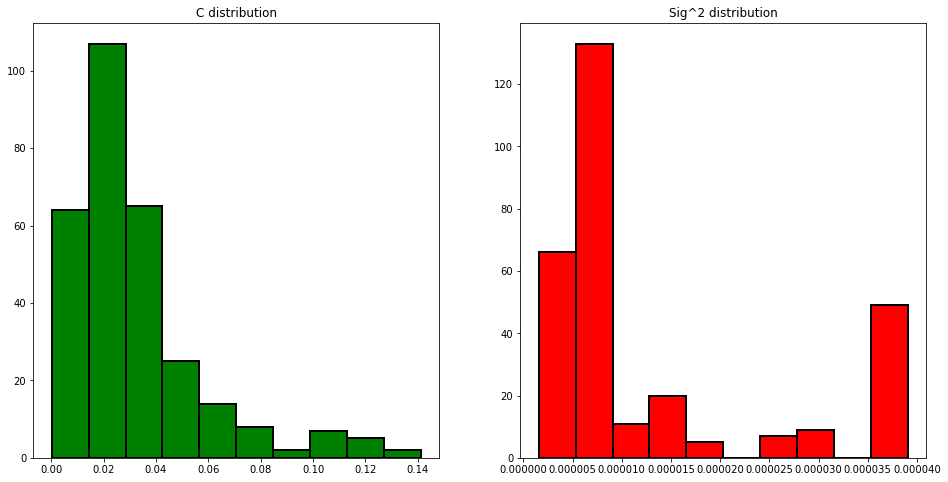

##########################################################################################
Processing example with alpha1: 3.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.535444498062134 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mean

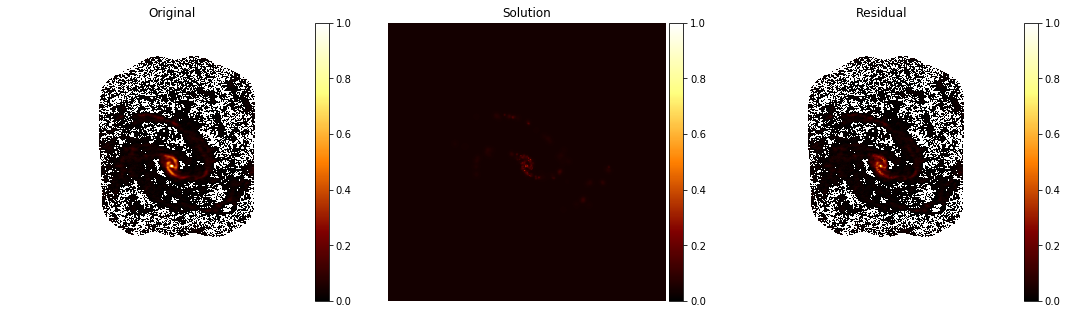

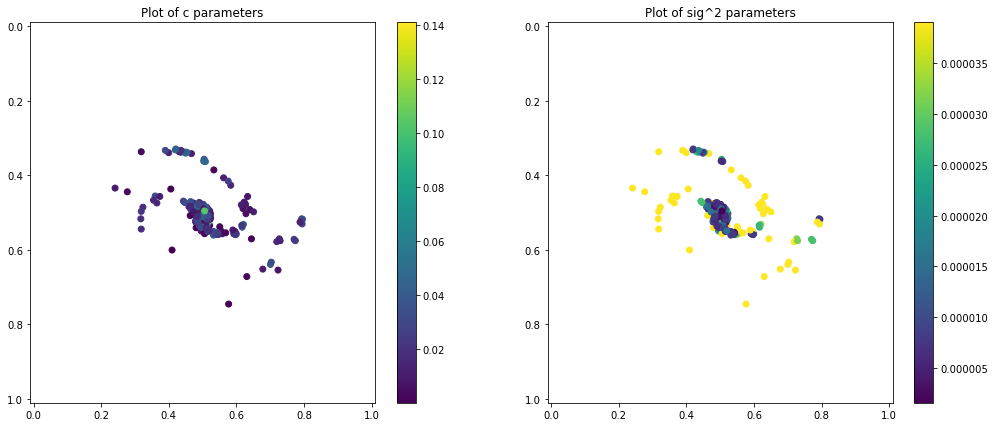

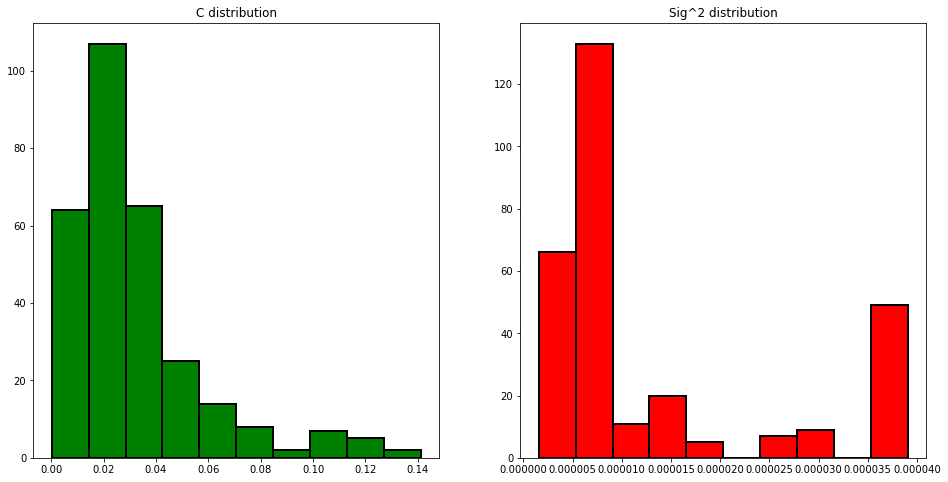

##########################################################################################
Processing example with alpha1: 4.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5238161087036133 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

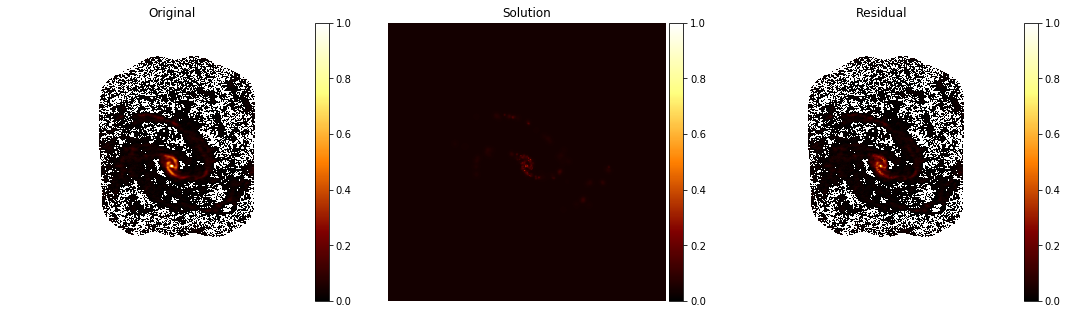

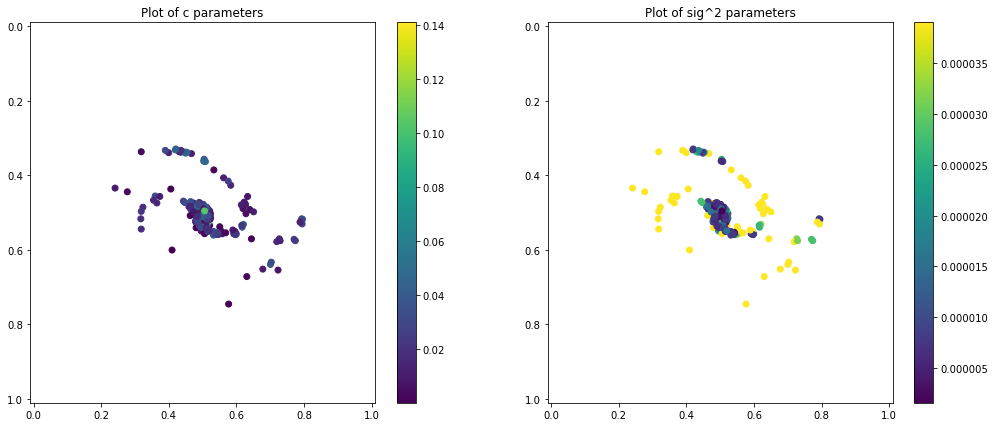

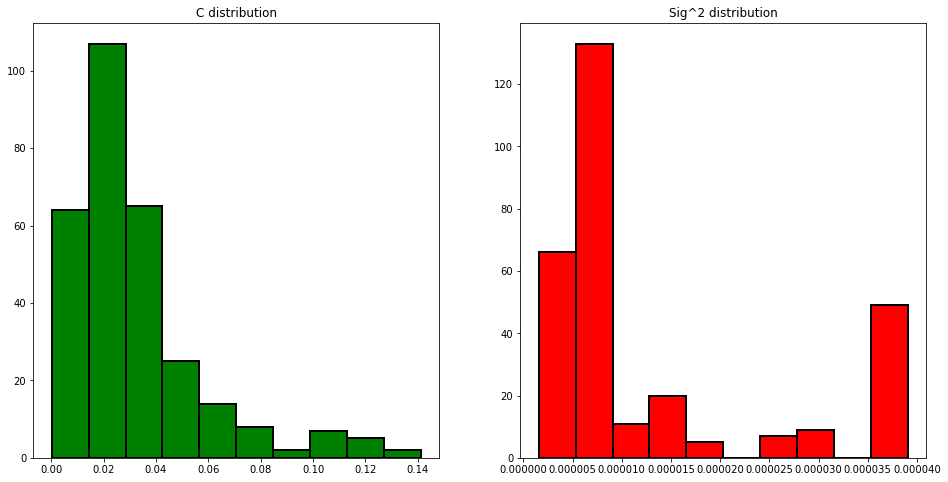

##########################################################################################
Processing example with alpha1: 4.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.526186227798462 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mean

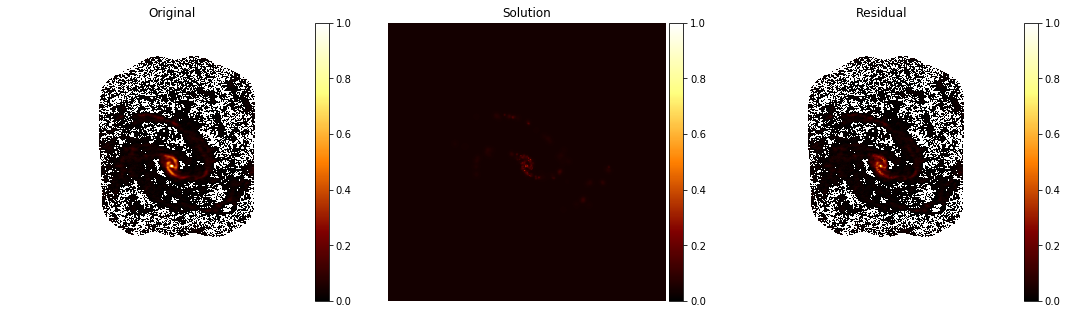

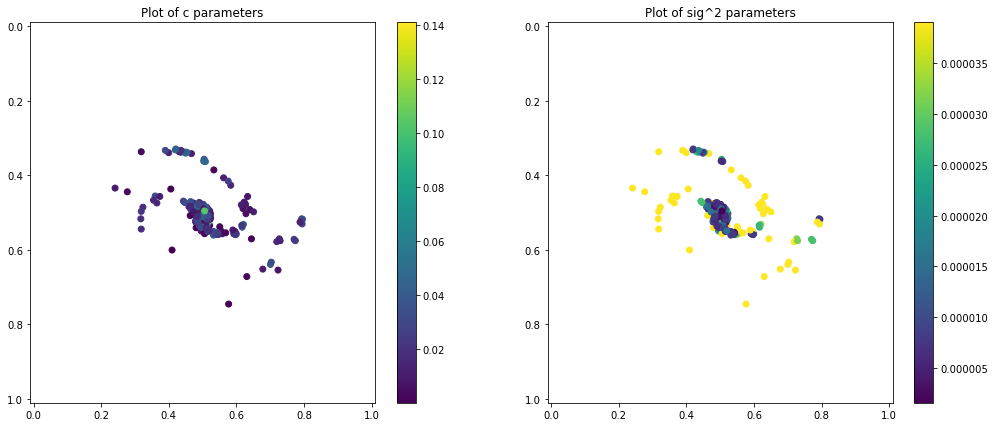

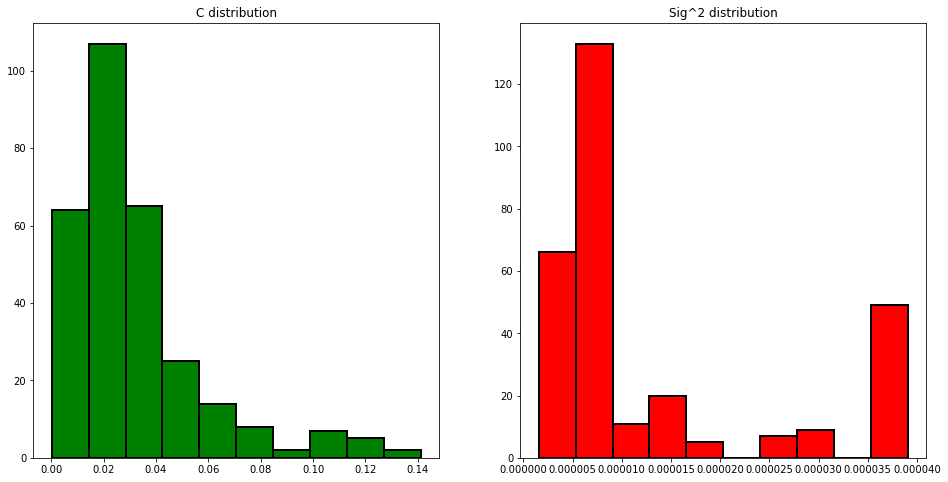

##########################################################################################
Processing example with alpha1: 5.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5380311012268066 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

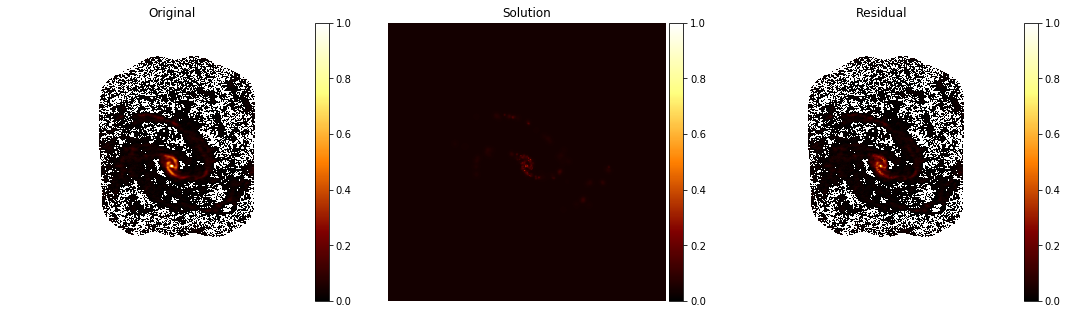

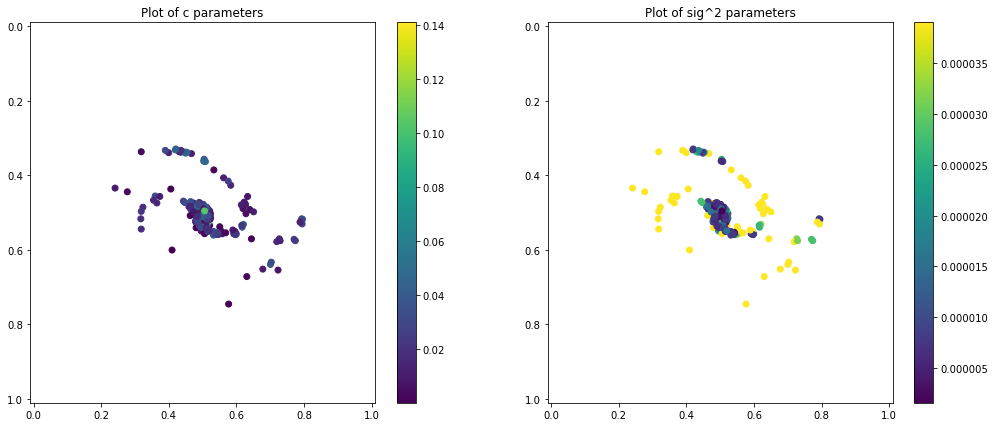

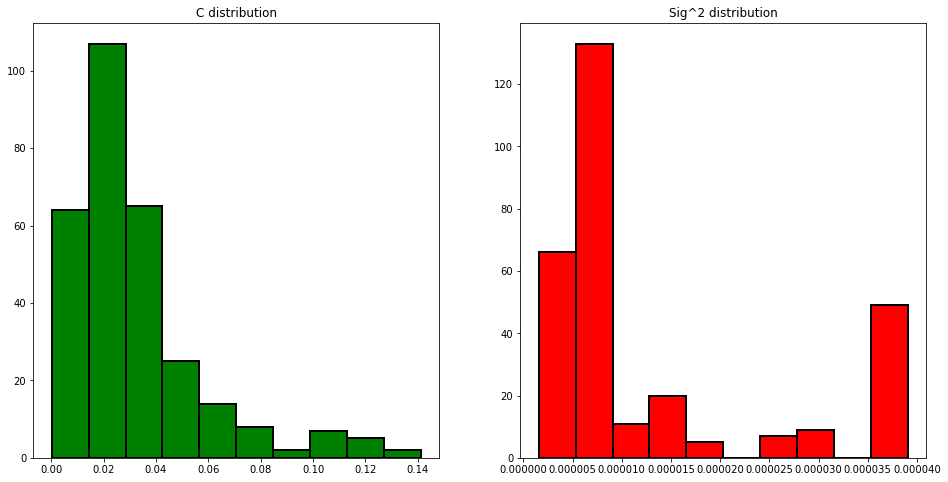

##########################################################################################
Processing example with alpha1: 5.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5287716388702393 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

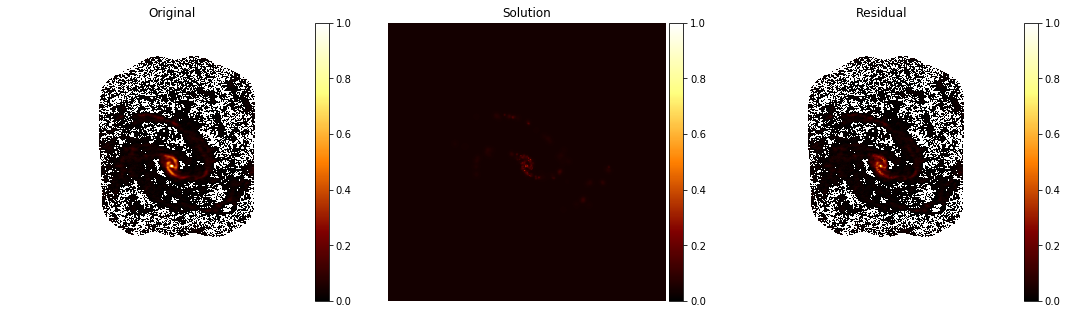

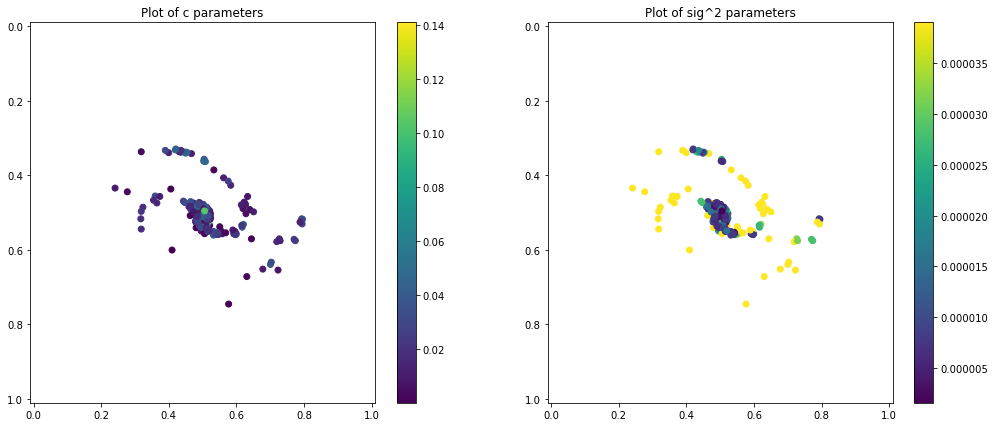

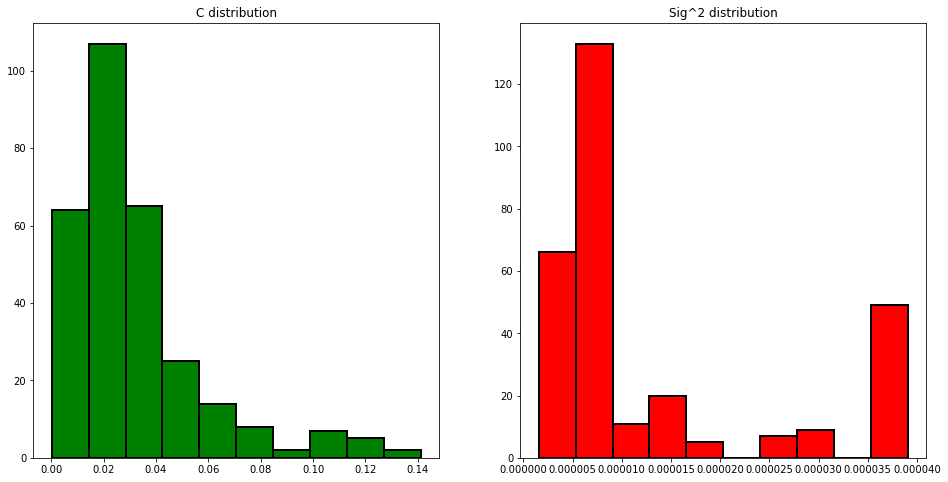

##########################################################################################
Processing example with alpha1: 6.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.52772855758667 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mean 

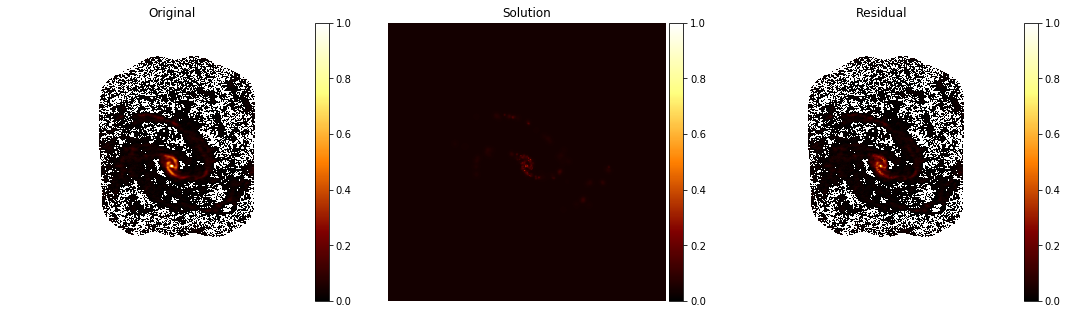

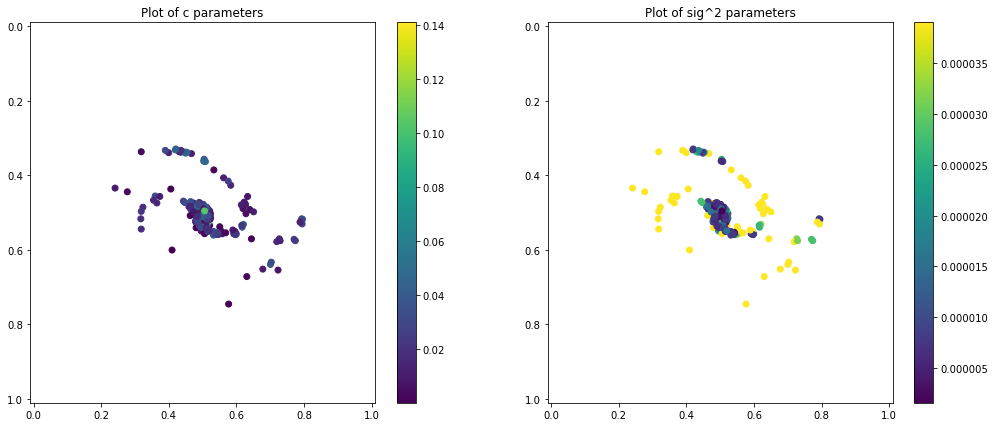

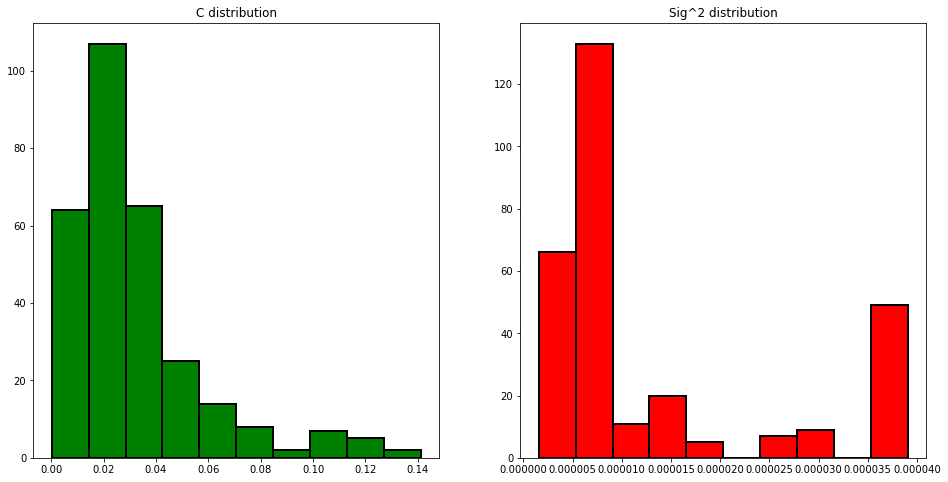

##########################################################################################
Processing example with alpha1: 6.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5364181995391846 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

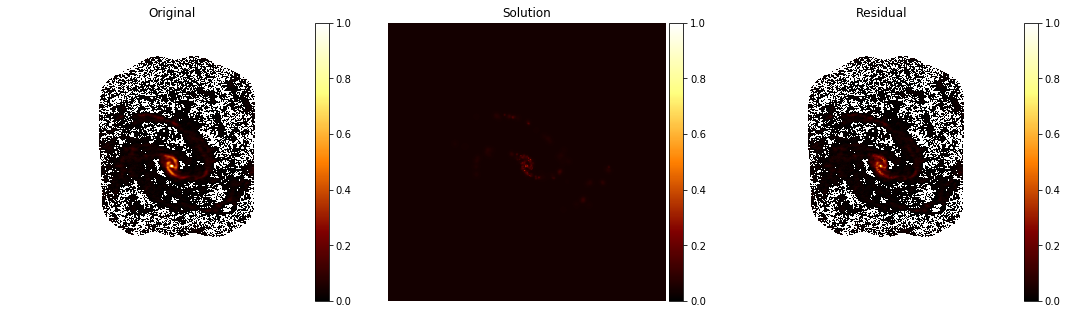

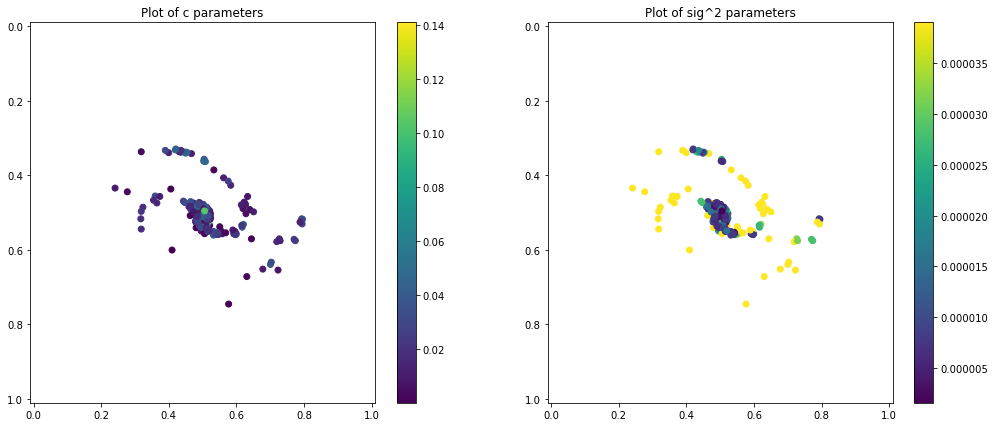

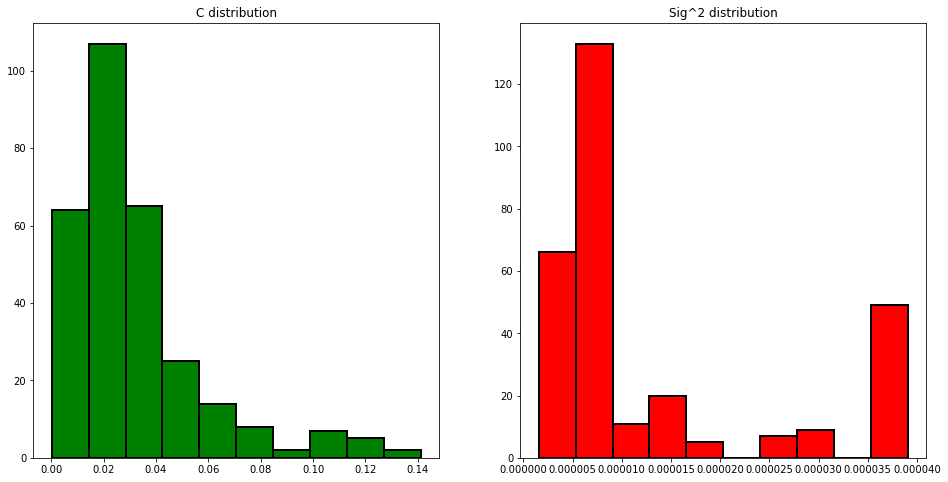

##########################################################################################
Processing example with alpha1: 7.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5285089015960693 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

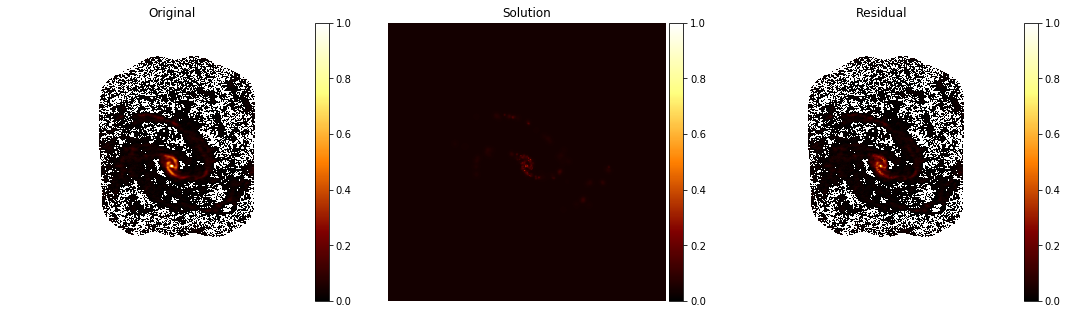

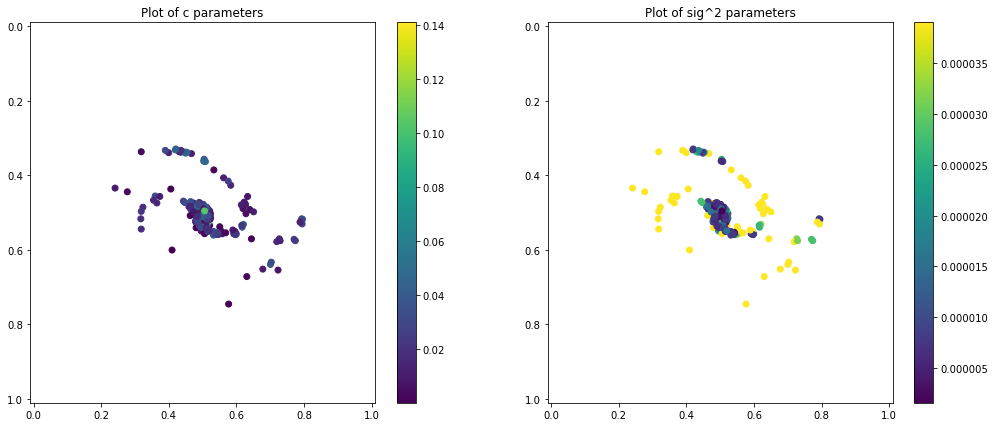

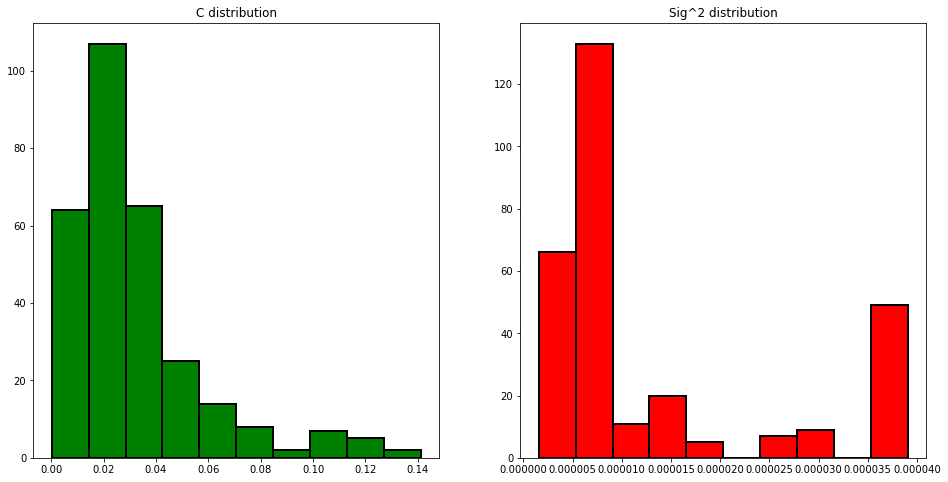

##########################################################################################
Processing example with alpha1: 7.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5330288410186768 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

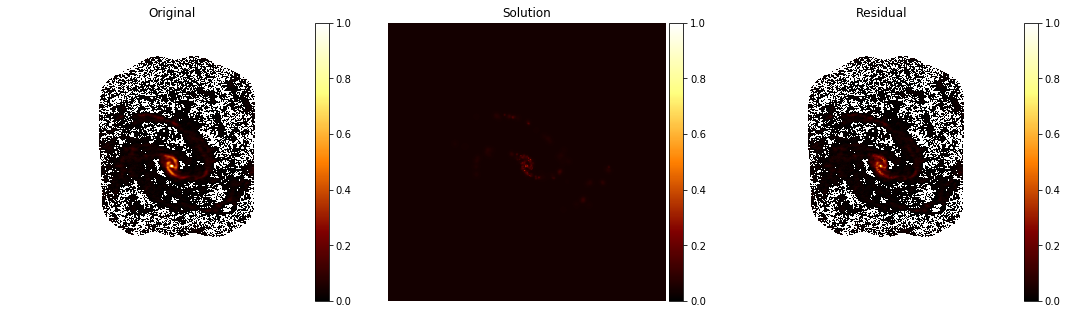

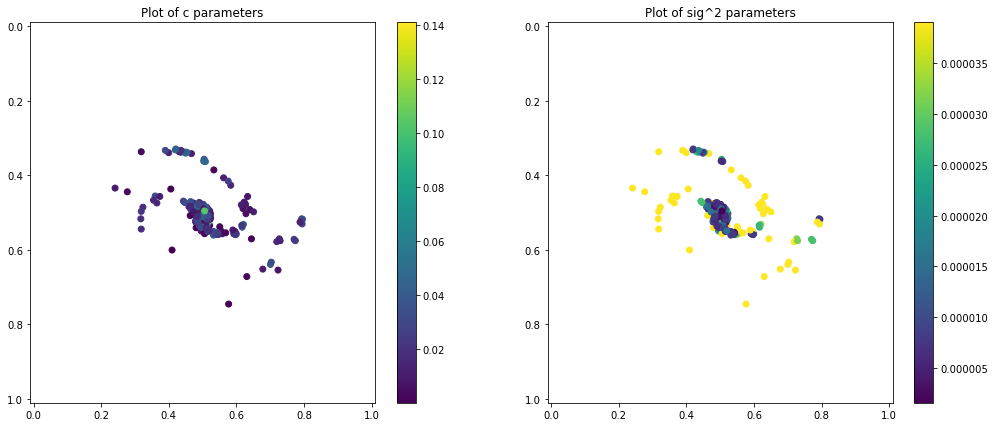

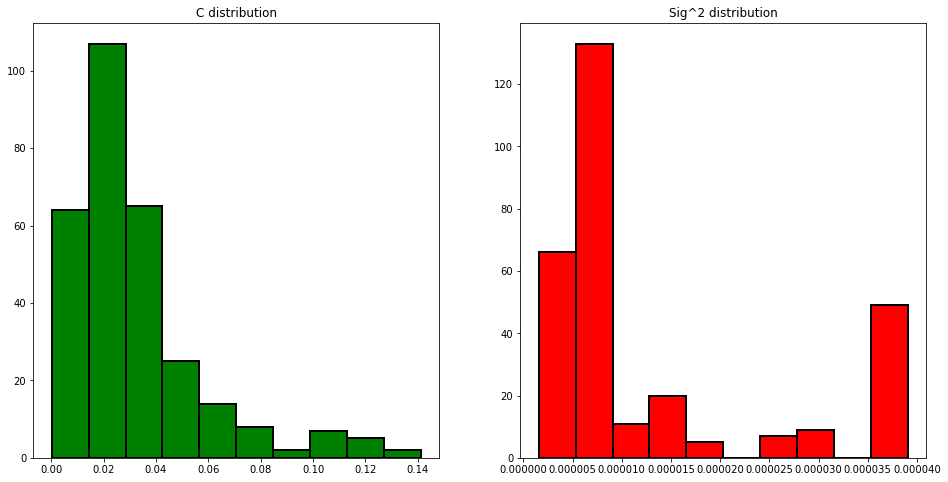

##########################################################################################
Processing example with alpha1: 8.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5395889282226562 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

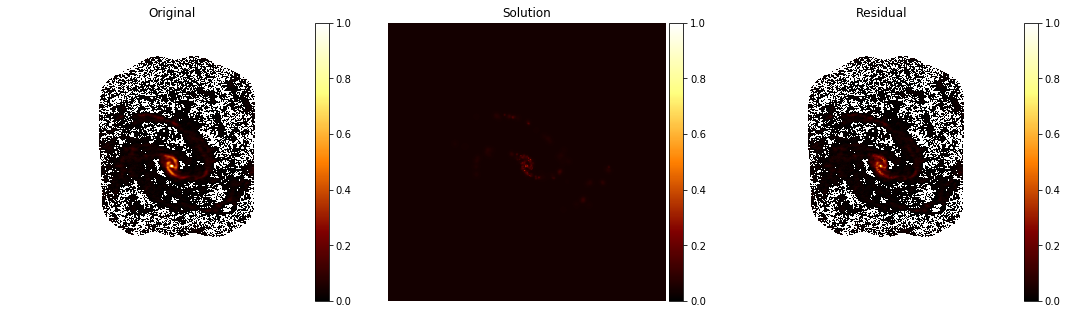

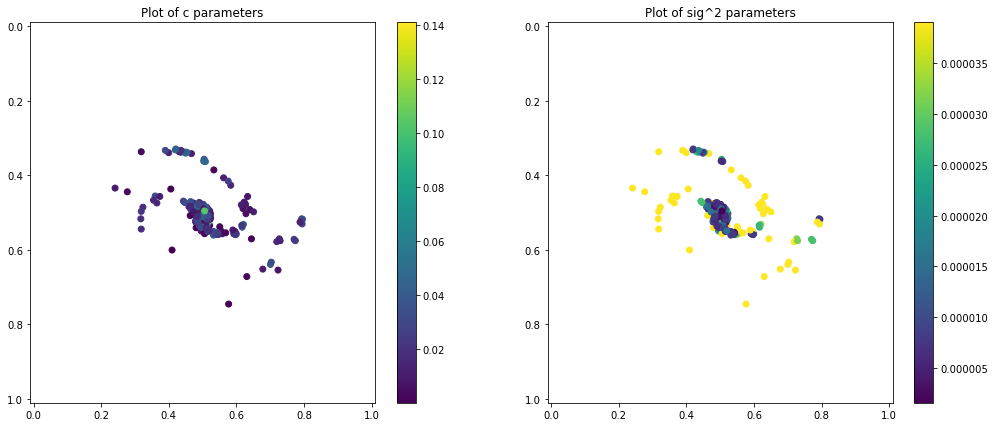

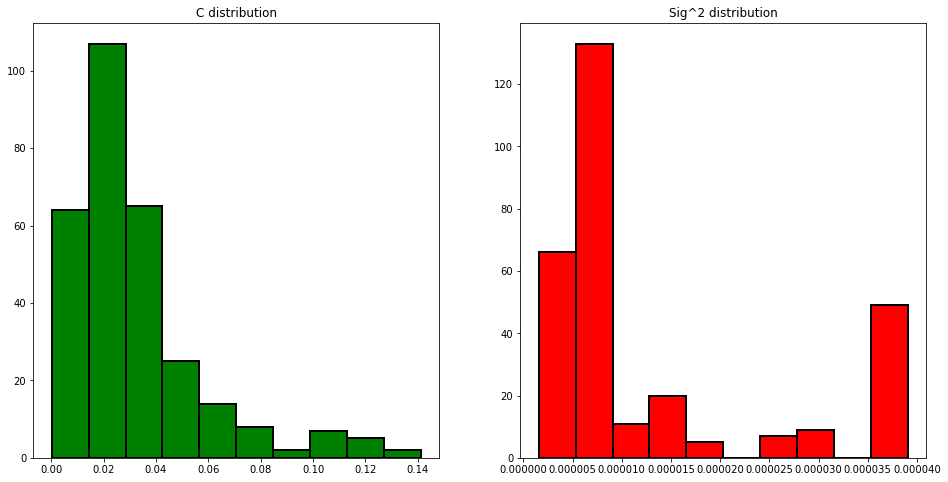

##########################################################################################
Processing example with alpha1: 8.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.5257351398468018 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

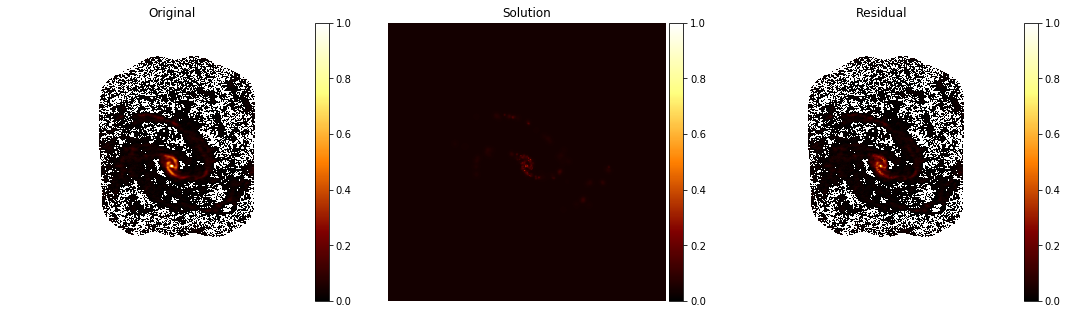

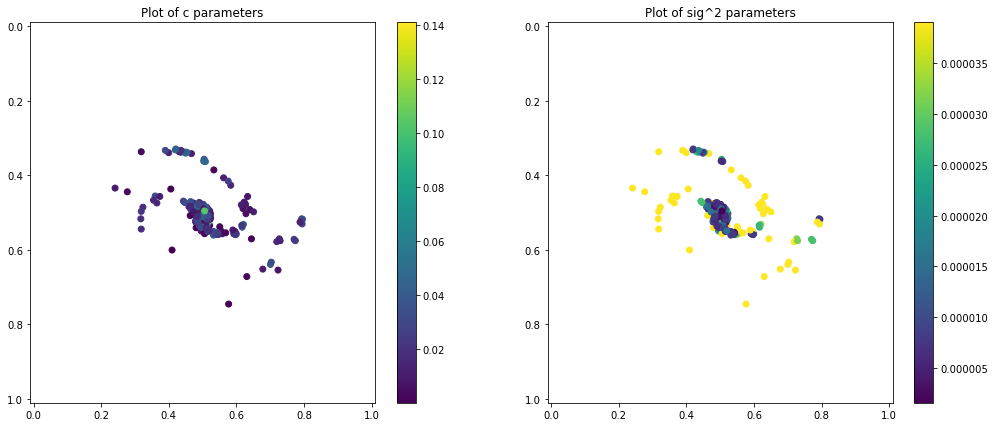

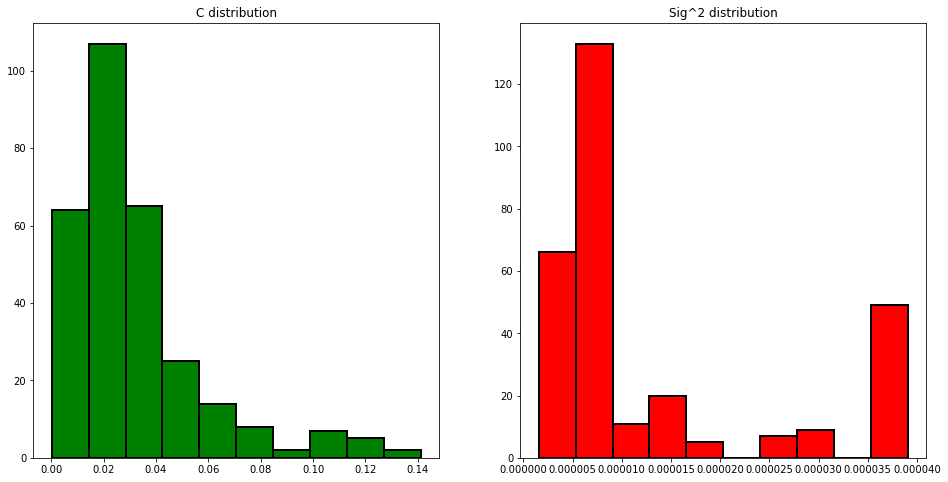

##########################################################################################
Processing example with alpha1: 9.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.533081531524658 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mean

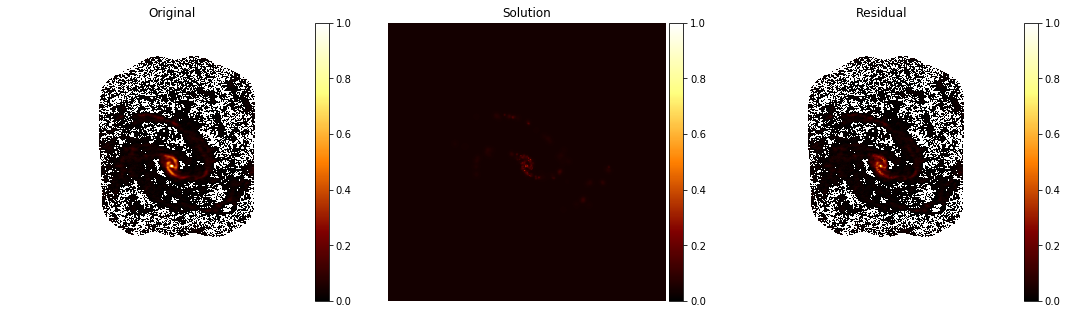

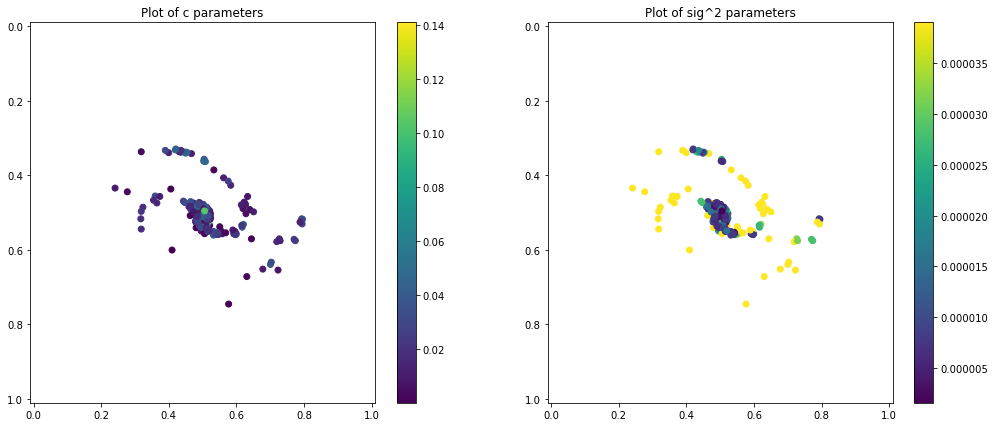

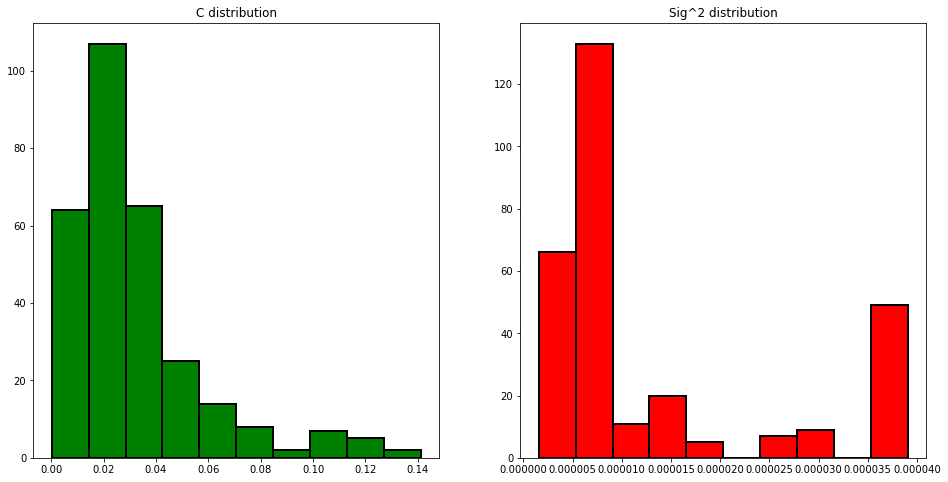

##########################################################################################
Processing example with alpha1: 9.5
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.529008150100708 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mean

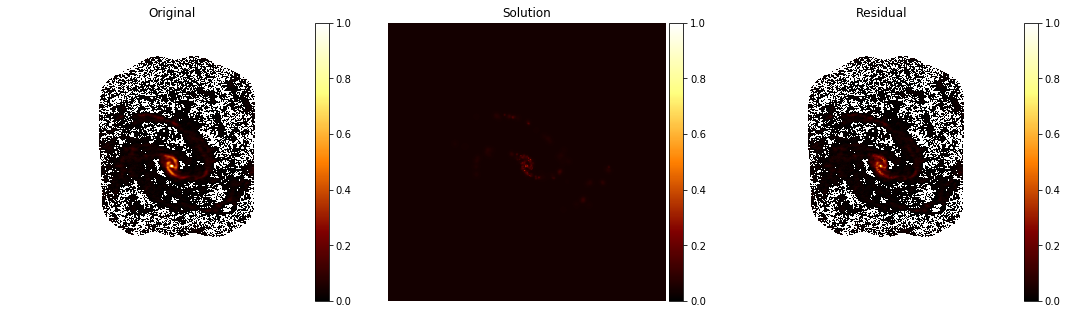

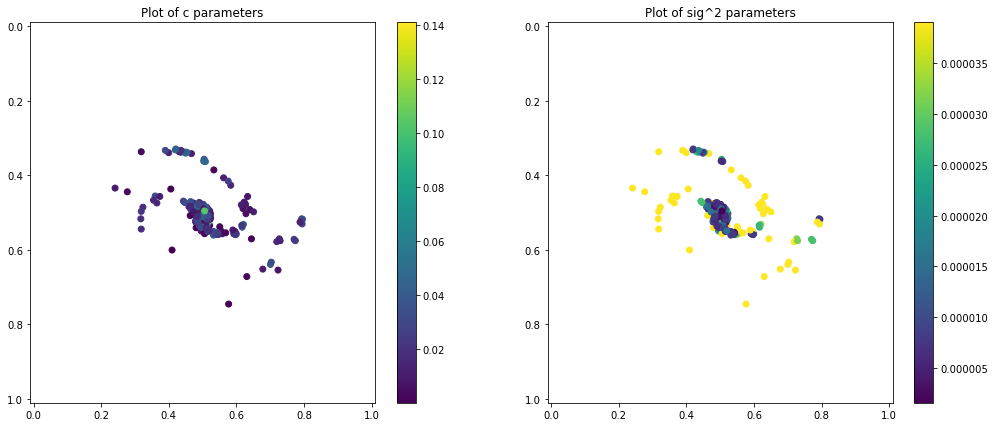

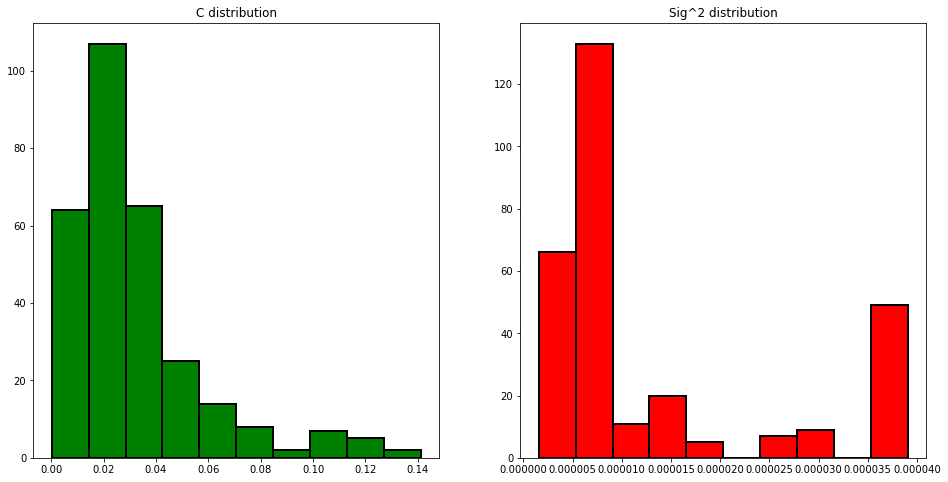

##########################################################################################
Processing example with alpha1: 10.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 3.529285430908203 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

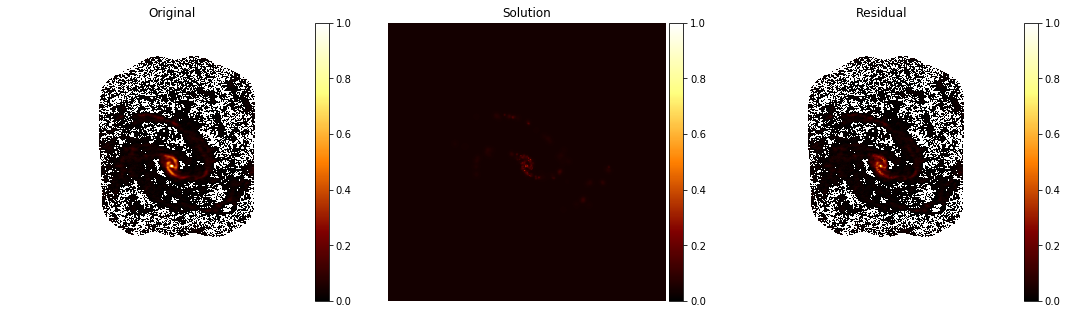

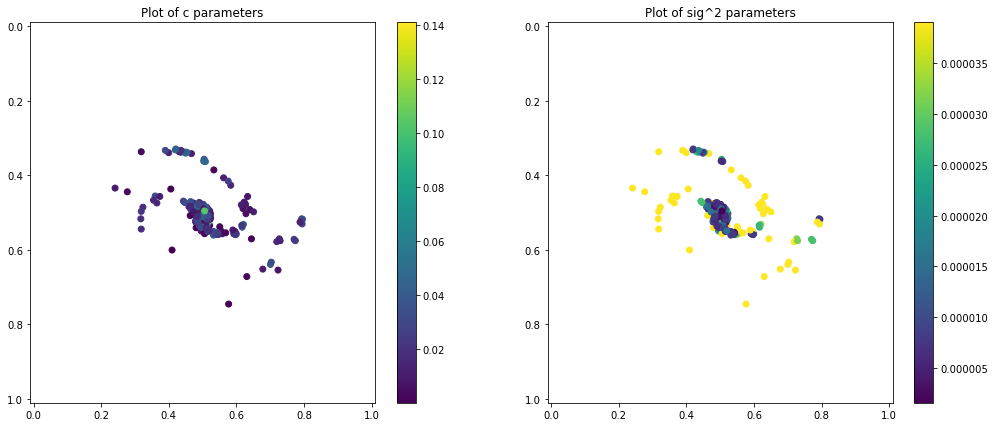

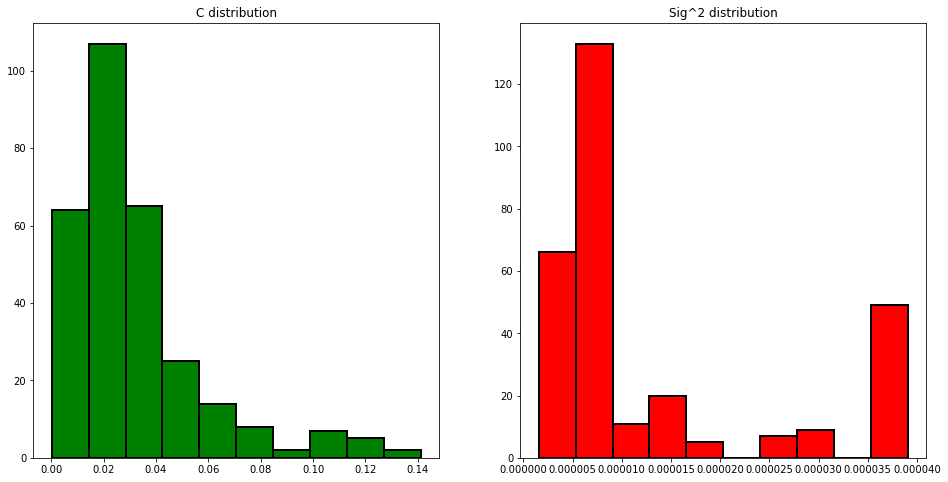

In [5]:
for elm in elm_list:
    print('#'*90)
    print('Processing example with alpha1: {0}'.format(elm.a))
    print('#'*90 + '\n')
    nfev = 100*(len(elm.get_params())+1)
    elm_solver(elm, method='standard', max_nfev=nfev)
    
#pickling results
target = open("exp02_alpha1_m100.pkl", "wb")
pickle.dump(elm_list, target)
target.close()

## `Case 2 `:   $\alpha_2 = [10^{-10},10^0]$ 

In [6]:
elm_list = list()
alpha2 = np.array([10**-n for n in range(0,11)])

for a2 in alpha2:
    # common parameters
    minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
    maxsig = 30*minsig

    # number of points of each type
    Nc = 300
    #Nb = int(0.2* np.sum(boundary_map(data, base_level))) #20% of boundary pixels
    Nb = int(0.2*Nc)
    Ne = 4*Nc-Nb

    # points generation
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)

    # right format
    xc = center_points[:,0]
    yc = center_points[:,1]
    xe = collocation_points[:,0]
    ye = collocation_points[:,1]
    xb = boundary_points[:,0]
    yb = boundary_points[:,1]

    ## visualizing the choosen points
    #points_plot(data, center_points=center_points, title="Center Points")
    #points_plot(data, center_points=collocation_points, title="Collocation Points")


    ####################################
    # Initial parameters estimation
    ####################################
    c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


    #solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
    #params_plot(c0, sig0, xc, yc)
    #params_distribution_plot(c0, sig0)
    elm_list.append( ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=0, lamb1=1., b=a2, lamb2=1.,
                    d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.) )

../lib/points_generation.py:28: RuntimeWarning: invalid value encountered in less_equal
  mask = data <= base_level
../lib/points_generation.py:126: RuntimeWarning: invalid value encountered in greater
  pixel_map = data > base_level
../lib/variational.py:79: RuntimeWarning: invalid value encountered in greater
  self.mask = data > base_level


##########################################################################################
Processing example with alpha2: 1.0
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.0646445751190186 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

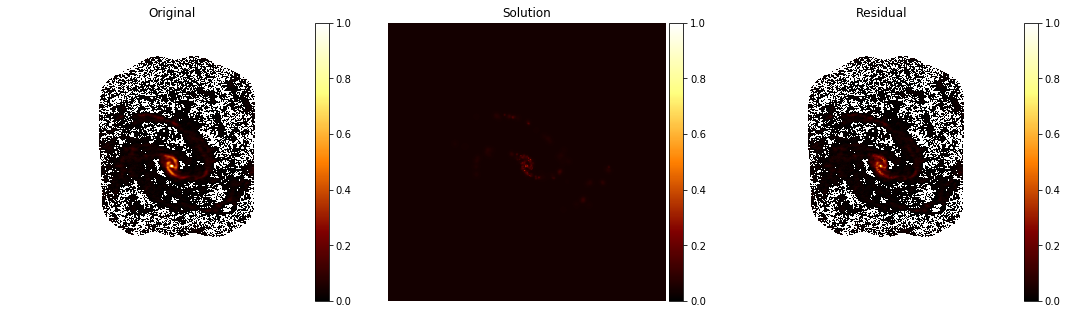

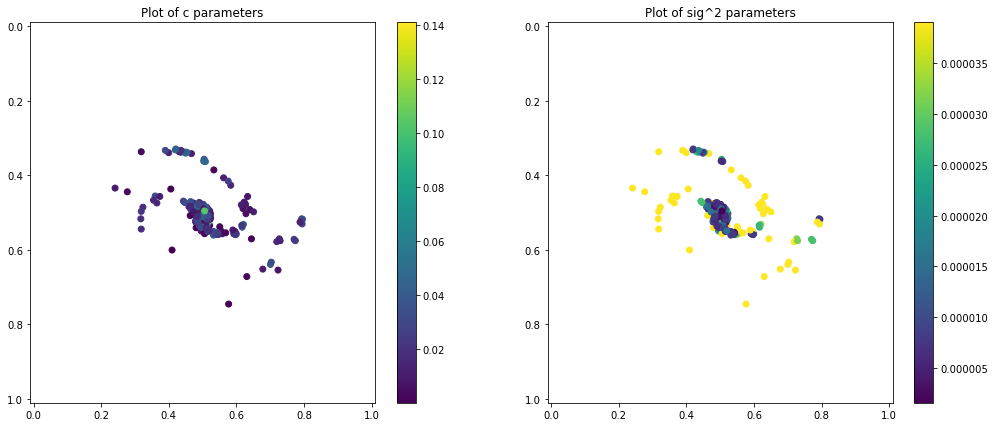

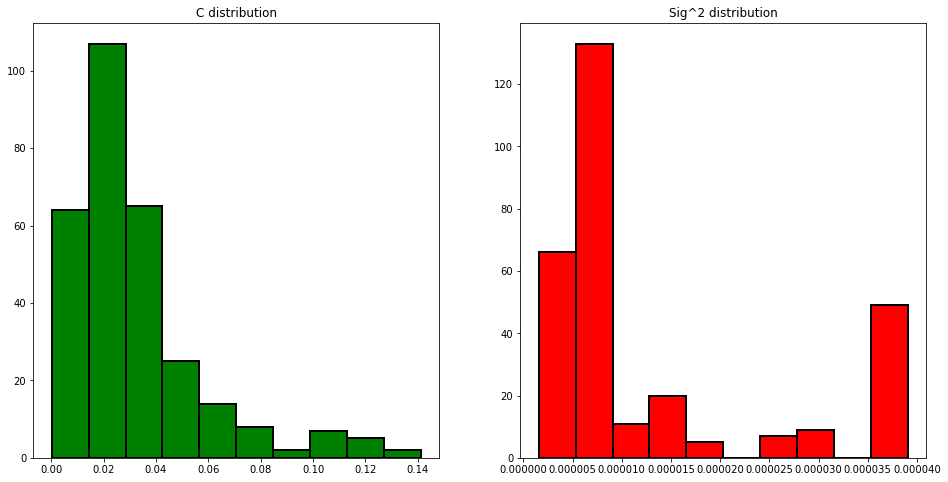

##########################################################################################
Processing example with alpha2: 0.1
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.063315391540527 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mean

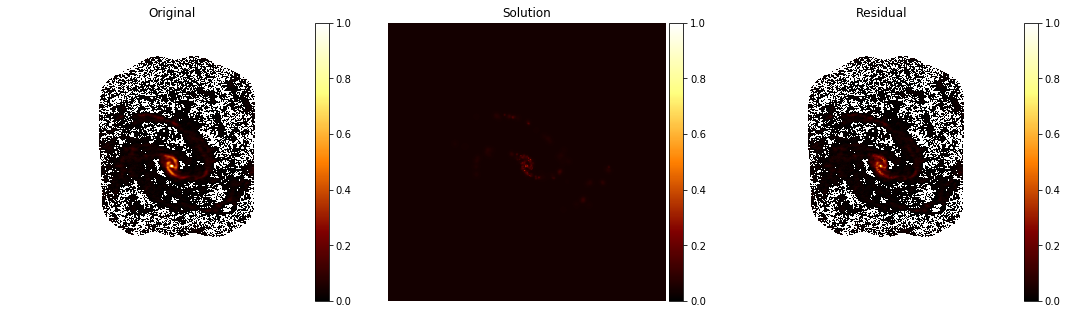

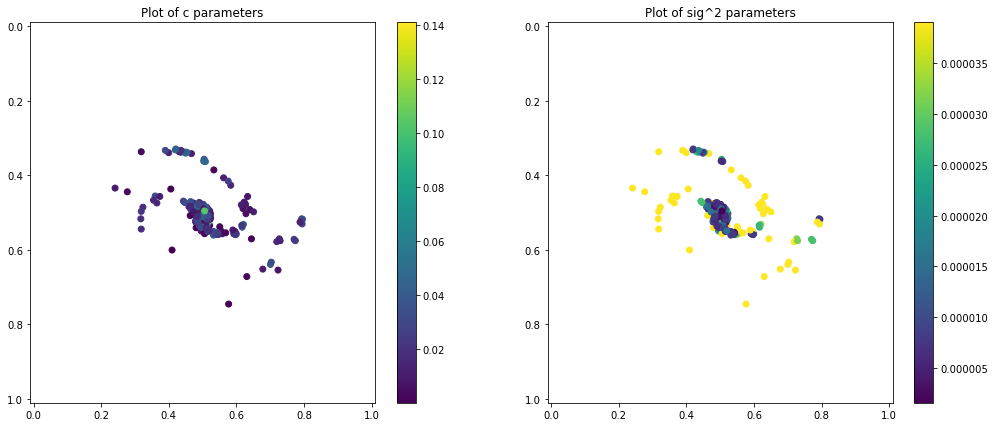

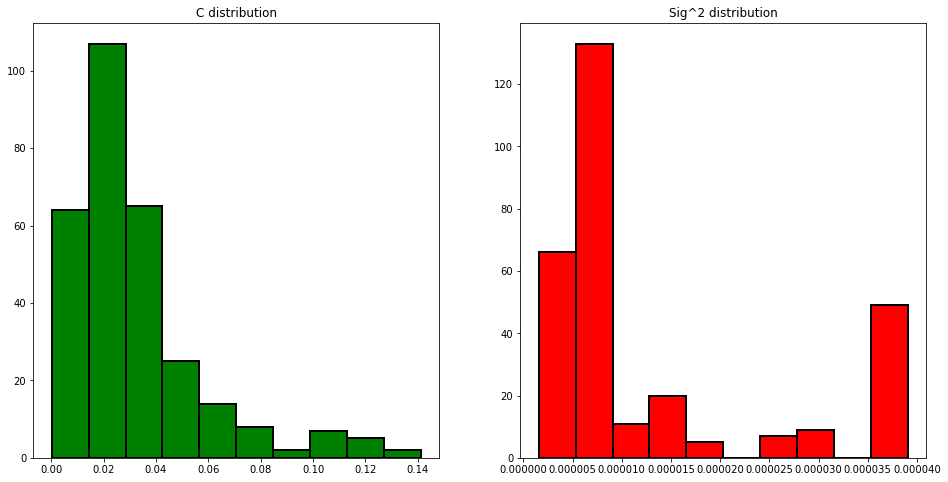

##########################################################################################
Processing example with alpha2: 0.01
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.080148458480835 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Mea

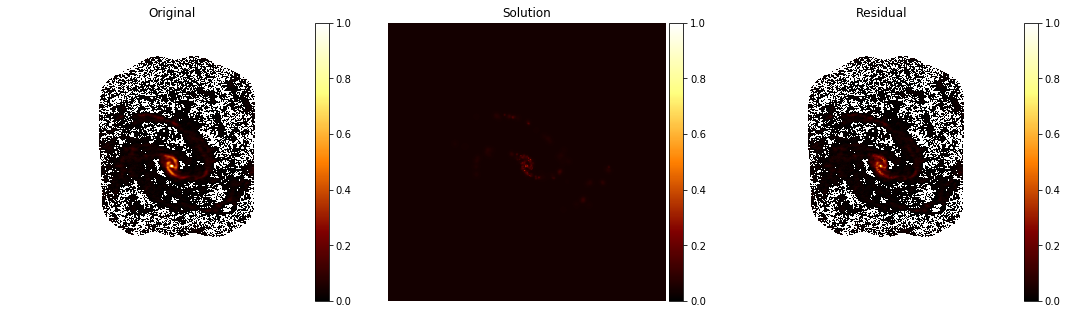

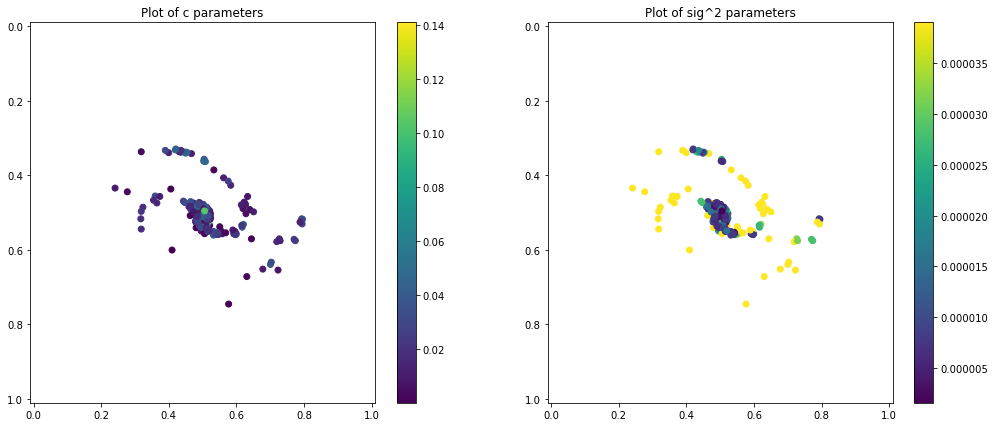

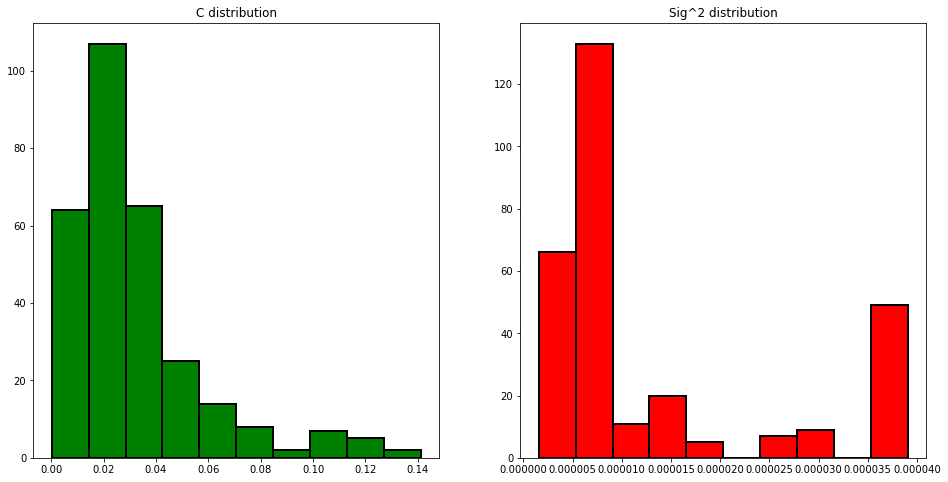

##########################################################################################
Processing example with alpha2: 0.001
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.063337564468384 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Me

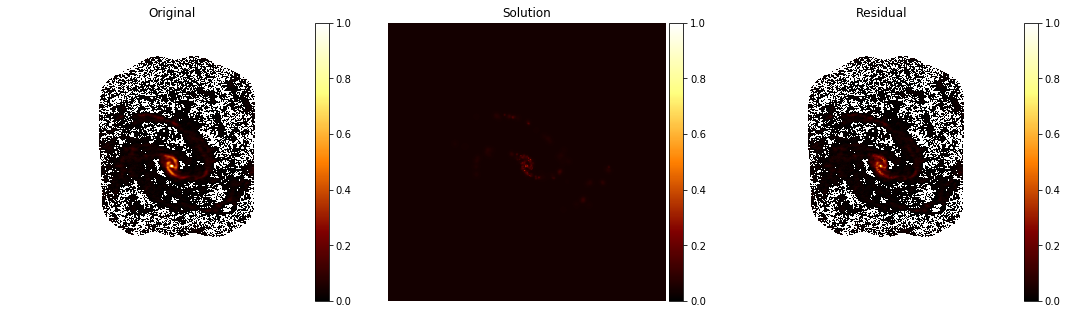

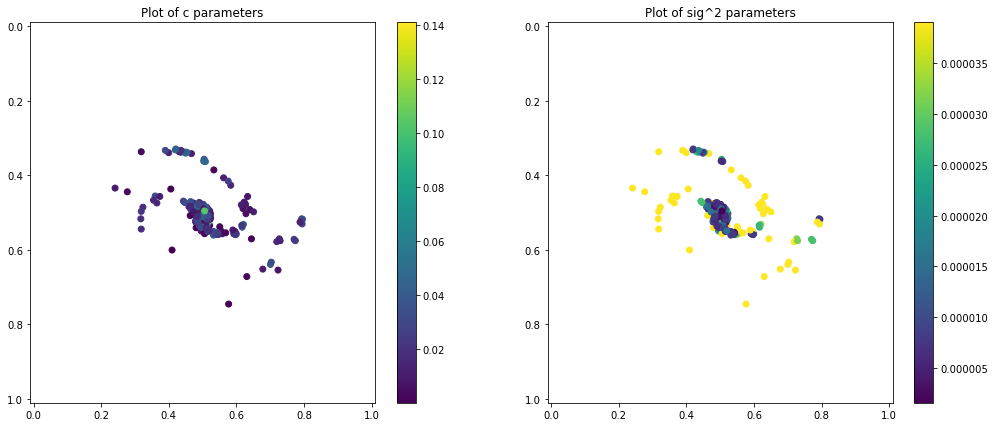

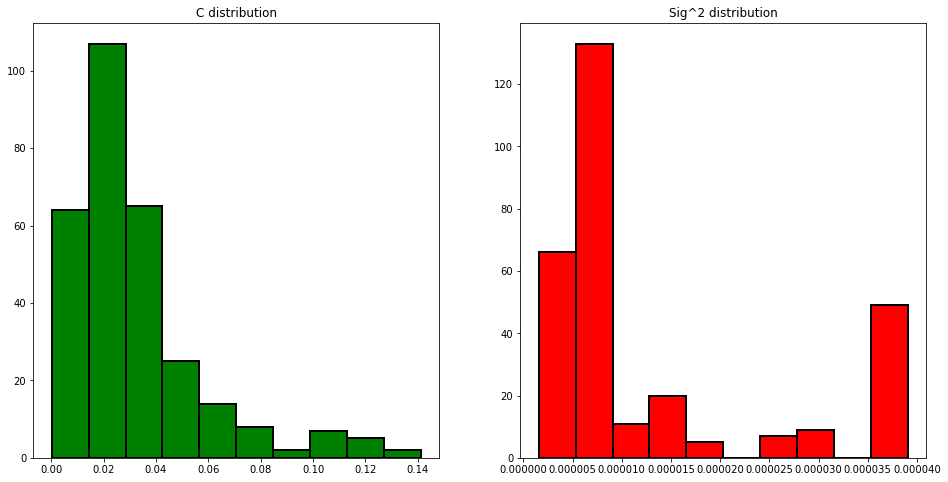

##########################################################################################
Processing example with alpha2: 0.0001
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.0705273151397705 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:


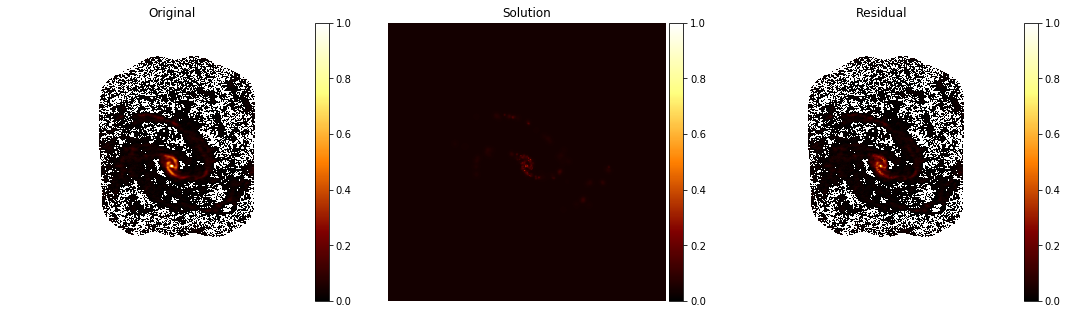

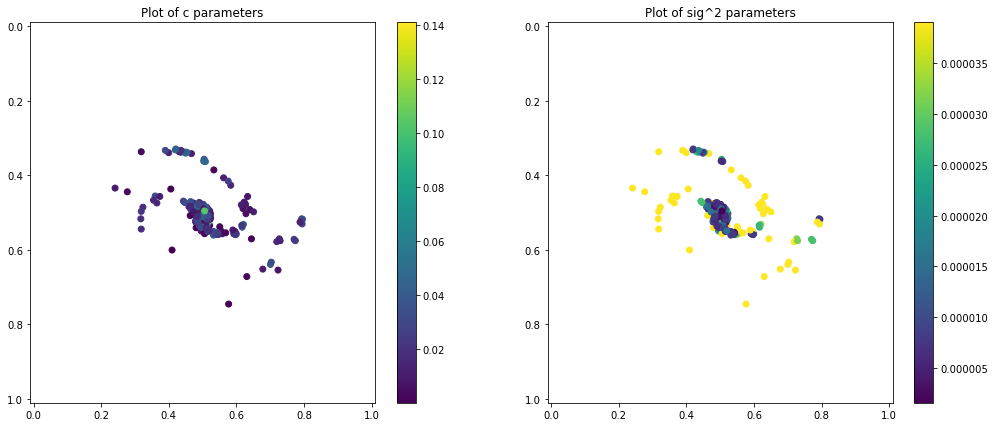

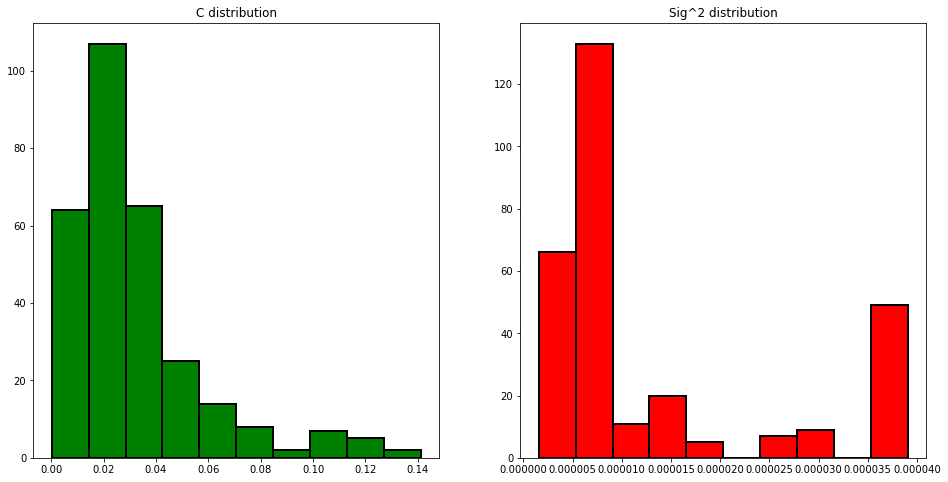

##########################################################################################
Processing example with alpha2: 1e-05
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.0707786083221436 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
M

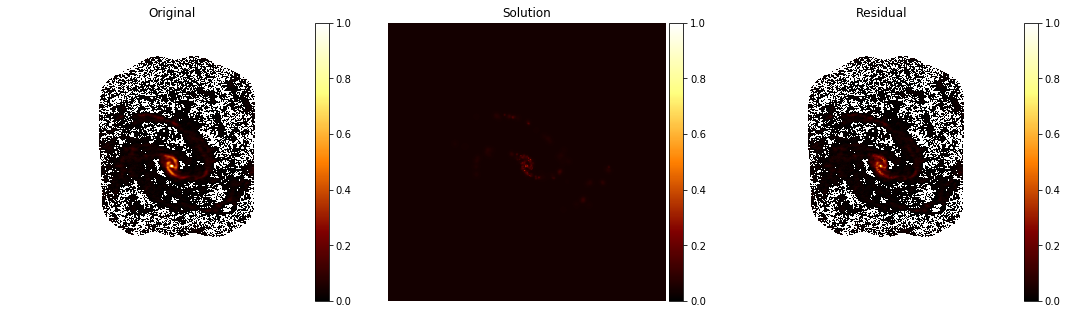

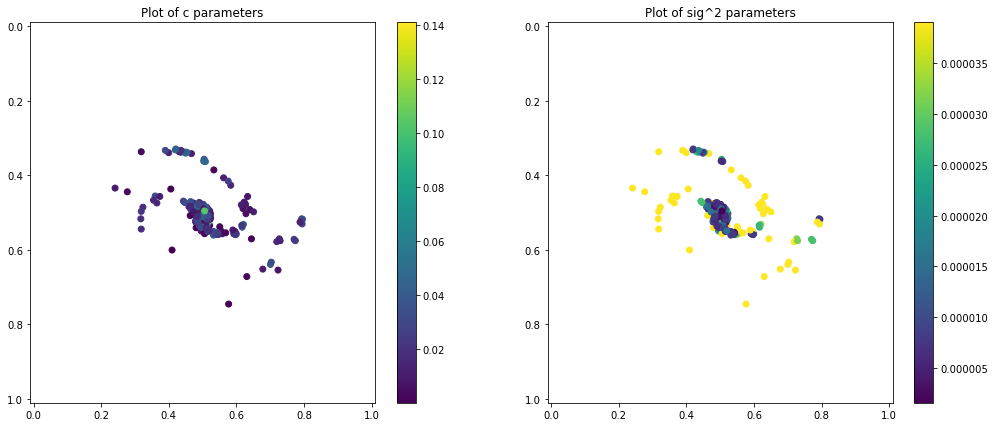

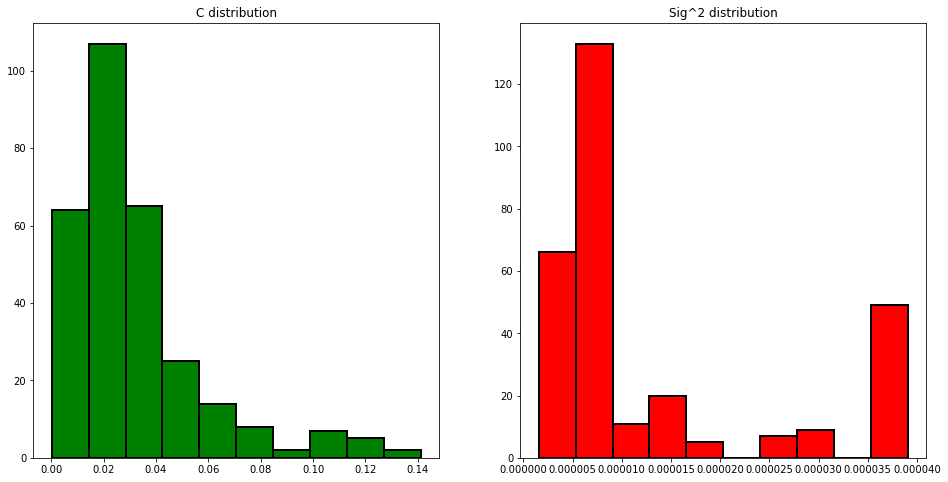

##########################################################################################
Processing example with alpha2: 1e-06
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.065882444381714 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Me

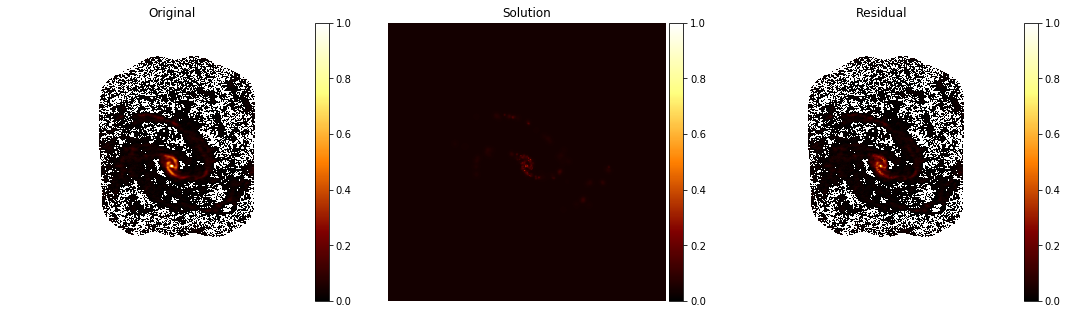

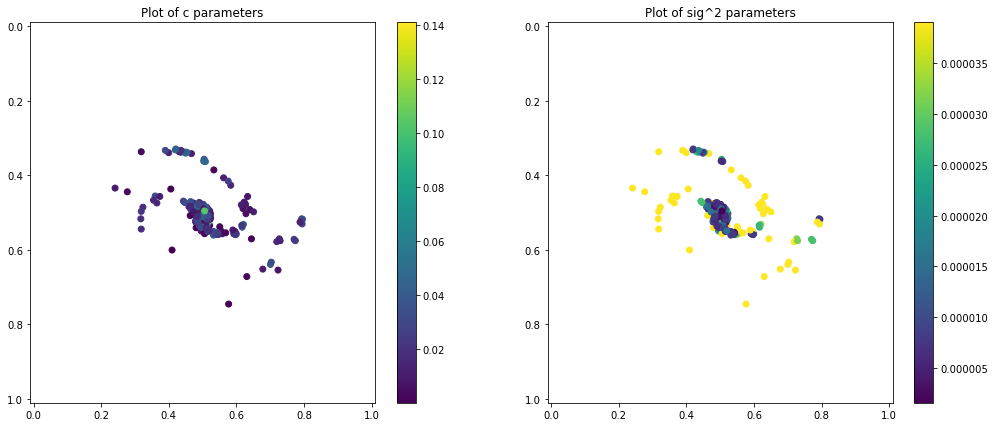

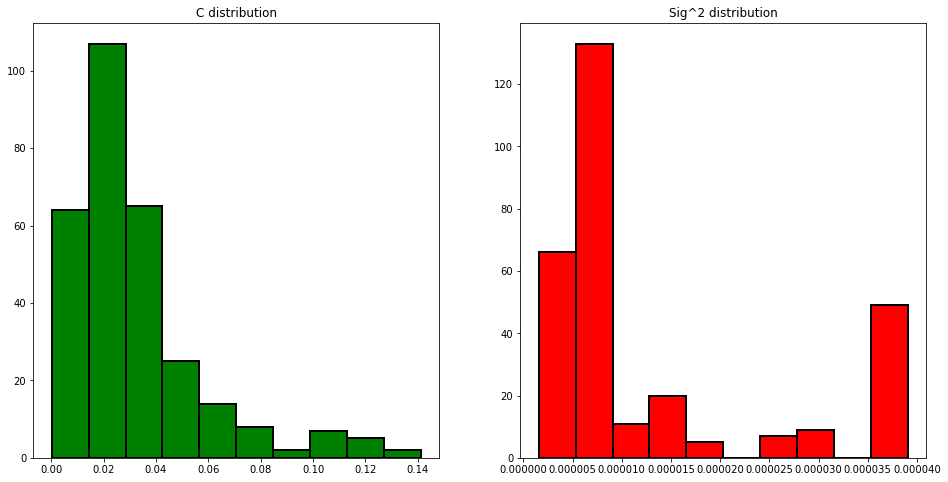

##########################################################################################
Processing example with alpha2: 1e-07
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.064055681228638 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Me

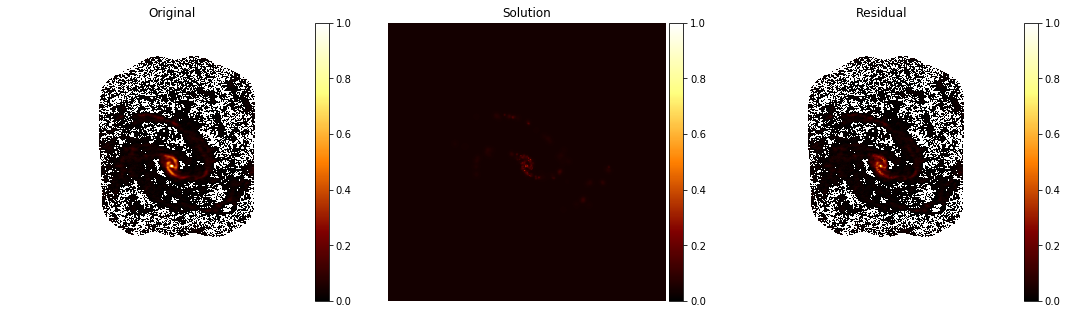

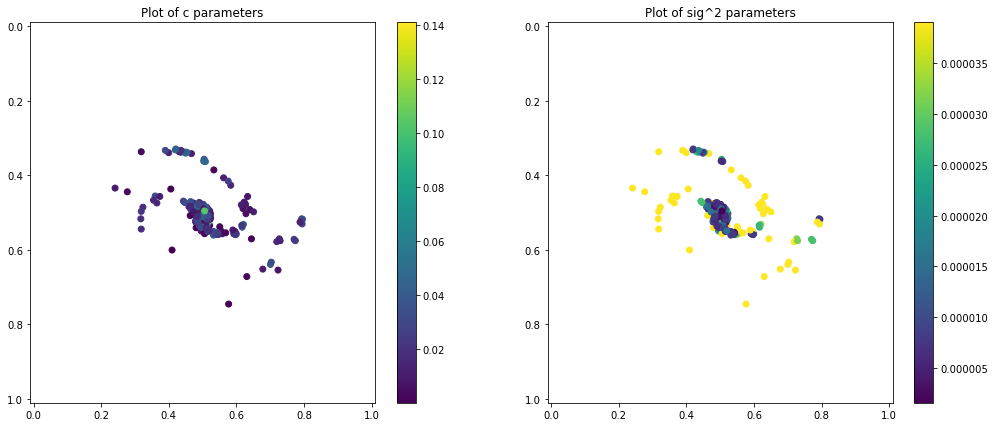

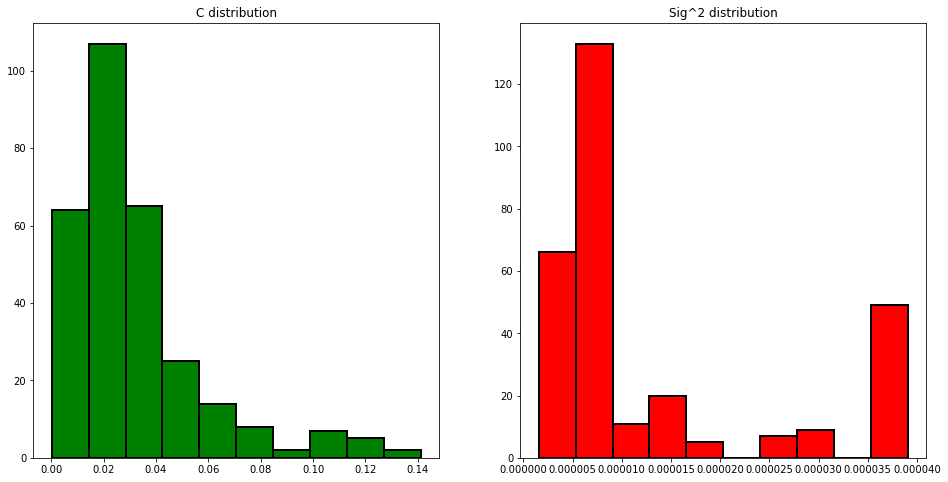

##########################################################################################
Processing example with alpha2: 1e-08
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.062798976898193 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Me

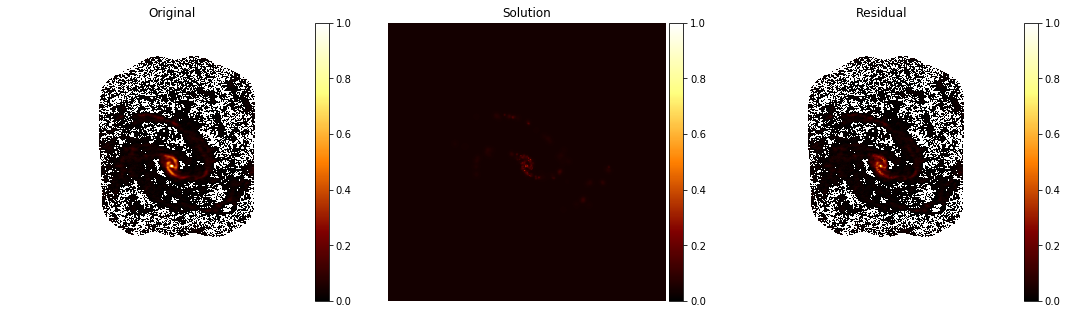

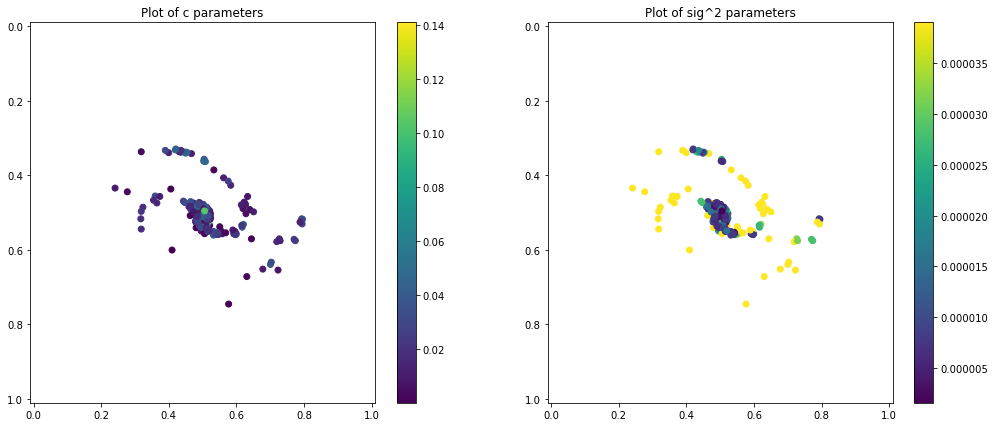

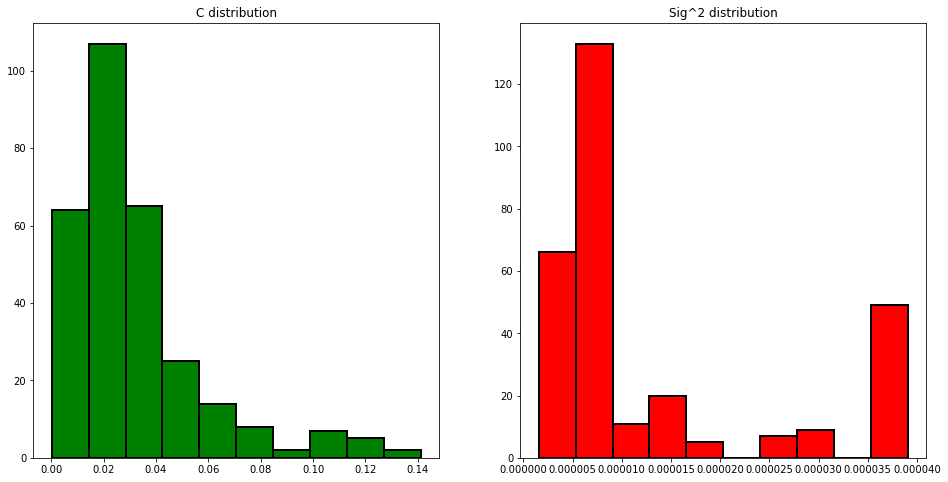

##########################################################################################
Processing example with alpha2: 1e-09
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.067531585693359 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Me

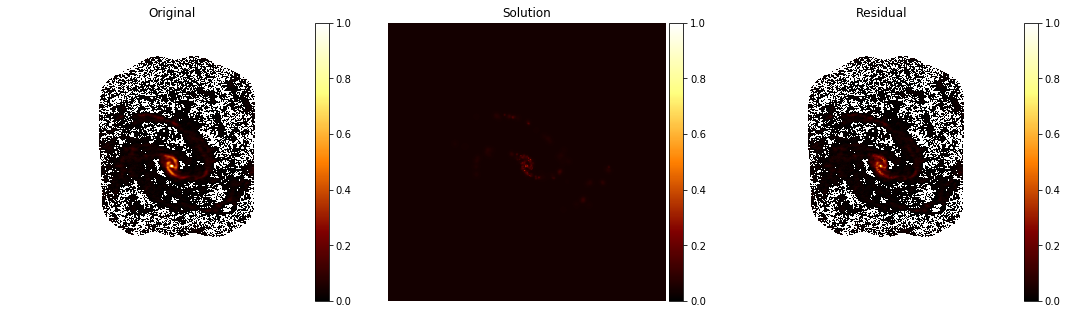

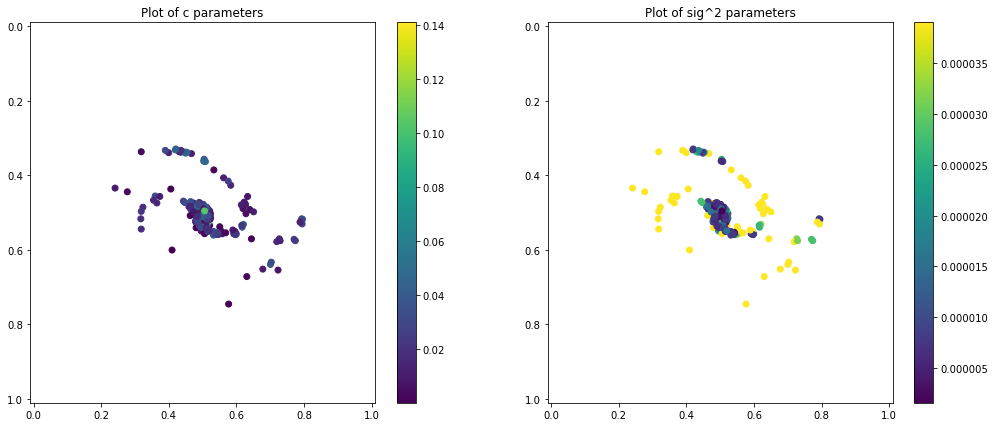

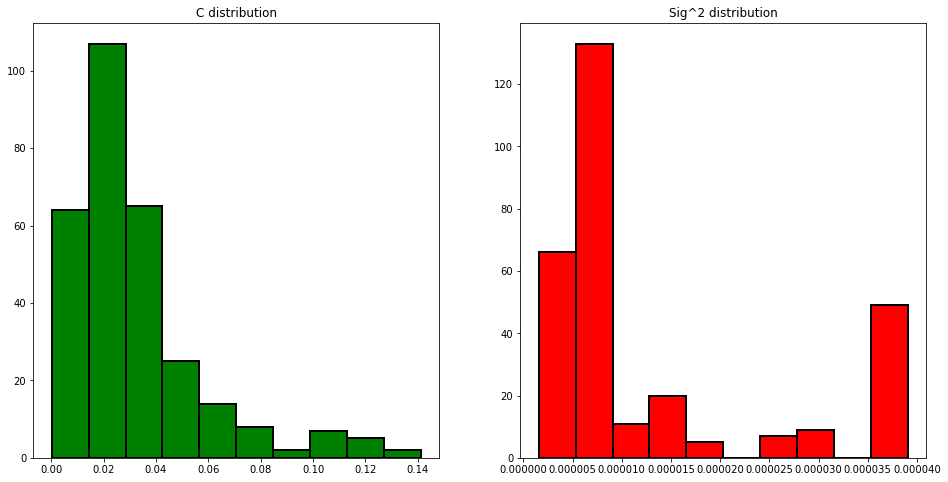

##########################################################################################
Processing example with alpha2: 1e-10
##########################################################################################


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 1201

Residual stats:
Residual RMS: 0.08563572024080907
Residual Variance: 0.0055869671208883965
Residual Entropy: 5.505829550809784
Added Flux: 17.431506243887306
Total elapsed time: 4.067669153213501 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26550470374761365
Mean min distance between collocation and center points: 0.013020513535140615

Homogeneity of solution:
Me

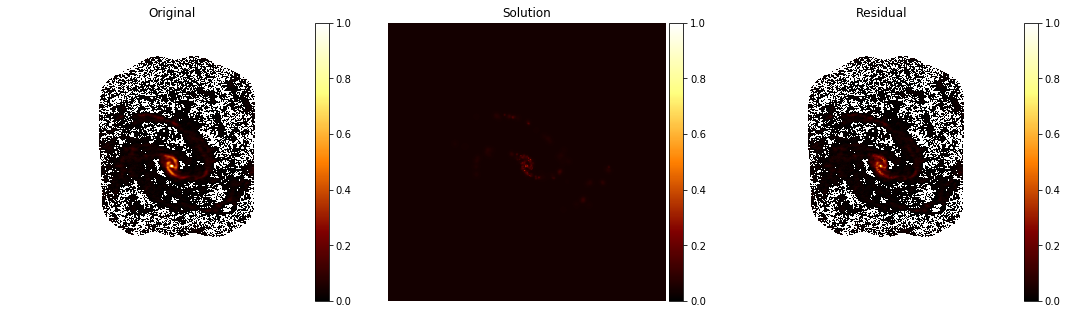

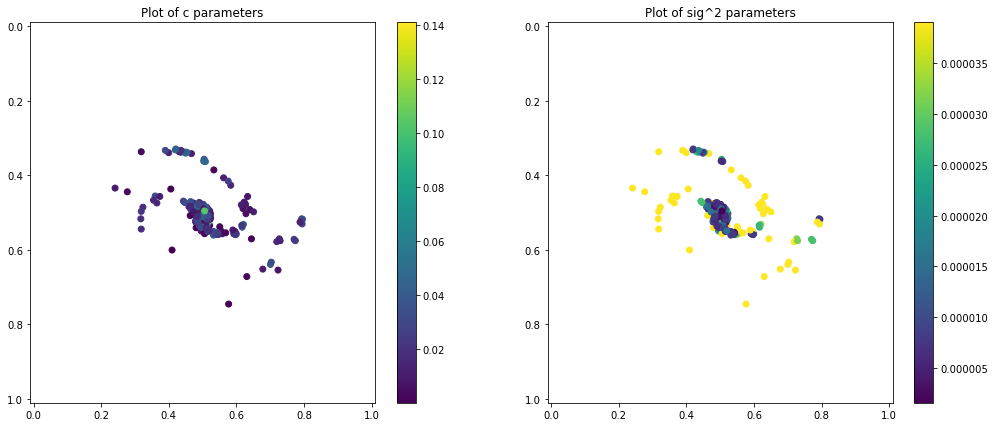

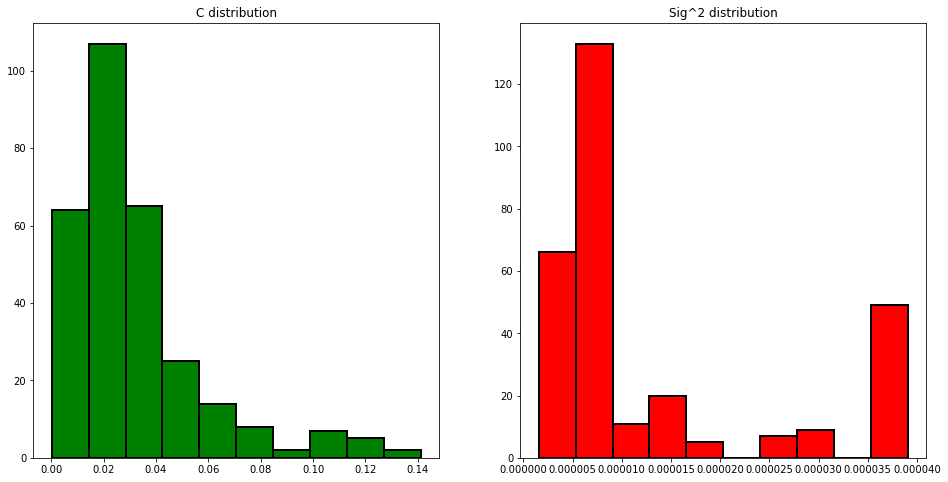

In [7]:
for elm in elm_list:
    print('#'*90)
    print('Processing example with alpha2: {0}'.format(elm.b))
    print('#'*90 + '\n')
    nfev = 100*(len(elm.get_params())+1)
    elm_solver(elm, method='standard', max_nfev=nfev)
    
#pickling results
target = open("exp02_alpha2_m100.pkl", "wb")
pickle.dump(elm_list, target)
target.close()